# Tutorial Code Use Jupyter Notebook
#### For more complex use, python notebookes are preferred, especially for interfacing with the multiprocessing package
#### When using a python notebook, the general use case should be as follows:

In [1]:
#import MC_19_Run_Functions as mc

#if __name__ == '__main__':
#    **insert code here**

## Manage Imports

In [2]:
import MC_Tutorial_Functions as mc #The Monte Carlo functions
import numpy as np  # Numerical operations and array manipulations
import matplotlib.pyplot as plt  # Plotting and data visualization
import pandas as pd  # Data structures for handling data (e.g., DataFrame)
import warnings  # To manage and control warnings during runtime
import copy  # Used for copying objects (shallow and deep copies)
import random  # Random number generation and random sampling
import scipy.stats as st  # Statistical functions and distributions from SciPy
import shapely as sp  # Geometry and spatial operations, primarily for handling shapes
from shapely.ops import polygonize  # Function to construct polygons from line geometries
import time  # Provides time-related functions, including time tracking
from sklearn.cluster import KMeans  # KMeans clustering algorithm from scikit-learn
from sklearn.metrics import silhouette_score  # Evaluation metric for clustering: Silhouette score
from sklearn.metrics import davies_bouldin_score  # Evaluation metric for clustering: Davies-Bouldin score
import multiprocessing as mp  # Allows for parallel processing to speed up computations
import time  # Duplicate import; possibly for another use related to time measurements
from scipy.spatial.distance import cdist  # Computes distances between points in multi-dimensional space
from scipy.optimize import linear_sum_assignment  # Solves linear sum assignment problems (e.g., optimal matching)
from scipy.interpolate import interp1d  # Interpolation tools for 1-D data
import ast  # Provides tools to work with Python's abstract syntax tree, useful for parsing and evaluating expressions
import matplotlib.pylab as pl  # Another module for plotting, similar to `plt` (not commonly used alongside `plt`)
import json  # JSON (JavaScript Object Notation) parsing and serialization
import os  # Provides a way to interact with the operating system, e.g., file handling, environment variables

## Generating a Sequence
##### Start by modifying the dictinary below. In the entry for each shape, the first entry is the shape ('s' for squares and 't' for triangles), the second is the orientation ('A' or 'B), and the final is the length of the patch (10 is default)

In [3]:
shapes = {'shape 1':['s','B',10],'shape 2':['s','B',10],'shape 3':['s','A',10],'shape 4':['t','B',10],'shape 5':['t','B',10],'shape 6':['s','B',10]}

##### The next code generates the arrays corresponding to the shapes, patches, and hinges of the sequence

In [4]:
hinge_vec, shape_arr, sequence, linelist, patch_arr = mc.generate(shapes)

##### The next line is unnecessary for the majority of simulations, but can be helpful for retrieving the sequence without using the above coode which is more computationally costly

In [5]:
sequence = mc.sequence_from_shapes(shapes)

##### Visually inspect the initial conformation of the sequence

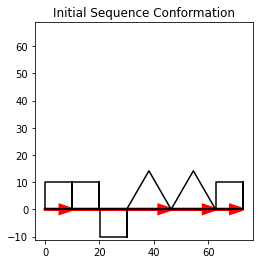

In [6]:
mc.shapeplots(shape_arr, linelist, blocking = False, title = 'Initial Sequence Conformation', show = True, bounds = '', mag_vecs = patch_arr)

##### Determine which junctions can move (which ones are hinges) and which ones are fixed

In [7]:
hinges = mc.moving_hinges(sequence) #Determine which indices in hinge_vec correspond to hinges
print('Hinges are located at indices: ', hinges)
nonhinges = mc.not_hinges(hinge_vec,hinges) #Determine which indices in hinge_vec correspond to rigid junctions
print('Hinges are not located at indices: ', nonhinges)
shape_ind, patch_ind, changes = mc. moving_indices(shape_arr, patch_arr, linelist, nonhinges, hinges) #Determine the indices in shape_arr and patch_arr that correspond
                                                                                                      #to rigid junctions

Hinges are located at indices:  [0 3 4]
Hinges are not located at indices:  [1, 2]


##### Randomly modify the overlap in rigid indices based on the experimental overlap distribiution

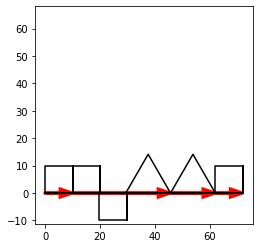

In [8]:
shape_arr_new, patch_arr_new = mc.vary_overlap(shape_arr,patch_arr, shape_ind, patch_ind, changes, dipole_len = 9.3, dipole_len_err = 0.4)
mc.shapeplots(shape_arr_new, linelist, mag_vecs = patch_arr_new)

##### Modify the overlap in rigid indices explicitly, deciding the amount of overlap (in microns) for each junction

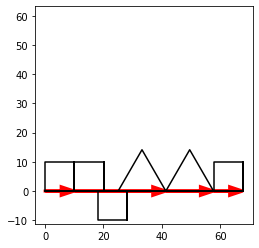

In [9]:
overlap_val = [2,3]
shape_arr_new, patch_arr_new = mc.vary_specific_overlap(shape_arr,patch_arr, shape_ind, patch_ind, changes, overlap_val)
mc.shapeplots(shape_arr_new, linelist, mag_vecs = patch_arr_new)

##### If overlap was modified, set the new patch and shape arrays

In [10]:
shape_arr = copy.deepcopy(shape_arr_new)
patch_arr = copy.deepcopy(patch_arr_new)

##### Count the number of shapes to keep track of overlapping. Note that the polygon count is not necessarily the number of shapes in the sequence

In [11]:
polycount = mc.count_shapes(shape_arr)
print(polycount)

8


#####  Check the overlap. Not necessary here, but will be used throughout the simulation

In [12]:
overlap = mc.check_overlap(shape_arr, polycount)
print(overlap)

False


##### Define the magnetization/length of each patch

In [13]:
m = [1.01e-6]*len(sequence)

##### Establish the magnetic vector containing all of the magnetizations/shape of each magnetic domain

In [14]:
magvec = mc.mag_vectors(sequence, m)

##### Initialize arrays used in the energy calculation of each sequence. (Keep in mind this code is optimized for speed over user-friendliness)

In [15]:
mask_arr, v_xmat, h_xmat, v_ymat, h_ymat, Ml_mat = mc.initialize_energy(magvec)

##### This code is not necessary here, but here is an example use of the function that calculates the actual energy ofthe sequence

In [16]:
E = mc.energy_math(patch_arr,mask_arr, v_xmat, h_xmat, v_ymat, h_ymat,Ml_mat)
print(E)

-6.117761490507605e-11


## Moving the shapes

##### This next code is not necessary to run on its own, but is included here for demonstration purposes, showing how the sequence moves. The general algorithm is: translate hinge to origin, rotate everything to the right of hinge using multiplication by teh rotation matrix, translate the hinge back to its position before the move

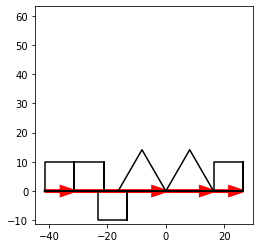

In [17]:
hingechoice = 3
patch_arr_new, shape_arr_new  = mc.translate_to_origin(patch_arr, shape_arr, linelist, hingechoice)
mc.shapeplots(shape_arr_new, linelist, mag_vecs = patch_arr_new)

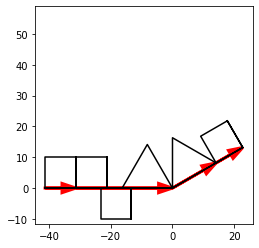

In [18]:
angle = 30
patch_arr_new, shape_arr_new, hinge_vec_new = mc.rotate(patch_arr_new, shape_arr_new, linelist, hinge_vec, hingechoice, hinges, angle)
mc.shapeplots(shape_arr_new, linelist, mag_vecs = patch_arr_new)

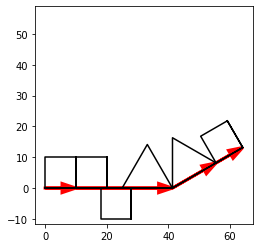

In [19]:
patch_arr_new,shape_arr_new = mc.translate_back(patch_arr_new,shape_arr_new)
mc.shapeplots(shape_arr_new, linelist, mag_vecs = patch_arr_new)

##### This whole operation can be done altogether using the function below:

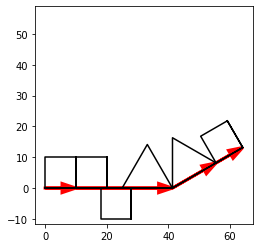

In [20]:
hingechoice = 3
angle = 30
patch_arr_new, shape_arr_new, hinge_vec_new = mc.rotate_once(patch_arr,shape_arr,linelist,hinge_vec,hingechoice, hinges, angle)
mc.shapeplots(shape_arr_new, linelist, mag_vecs = patch_arr_new)

## Establish the Reference Energy for the Sequence

##### This function establishes the reference energy in each hinge based on the standard deviation from which angles are drawn and the initial angle that sets how far along the path annealing should begin

In [21]:
std = 10
initial_angle = 30
E_refs, E_lows = mc.characteristic_energy(std, sequence, patch_arr, shape_arr, hinge_vec, linelist, polycount,
                                         initial_angle, mask_arr, v_xmat, h_xmat, v_ymat, h_ymat,Ml_mat)
print(E_refs)
print(E_lows)

[2.908096887760153e-17, 1.2082257373337085e-16, 5.622410849353764e-17, 5.713748731214278e-17, 2.835702679308758e-17]
[-6.11776410005792e-11, -6.117766522678873e-11, -6.117766522678873e-11, -6.117764034895473e-11, -6.117764034895473e-11]


##### The mean of these values that are calculated independently for each hinge is typically taken to serve as the actual value for refereence energy as well as the energetic value at which to begin annealing

In [22]:
E_ref_initial = np.mean(E_refs)
E_low = np.mean(E_lows)
print('Initial Reference Energy Change: ', f"{E_ref_initial:.3e}",' Joules')
print('Energy at which to begin annealing: ', f"{E_low:.3e}", ' Joules')

Initial Reference Energy Change:  5.832e-17  Joules
Energy at which to begin annealing:  -6.118e-11  Joules


## Monte Carlo Simulation

### Run Simulation One Time

##### Initialize some of the base simulation parameters. The parameters picked below are either standard or the standard method for determination

In [23]:
moves = 1000 #Number of moves after which to prematurely terminate simulation
anneal_steps = 100 #Hop many MC steps the annealing should take place over
anneal_rate = E_ref_initial/anneal_steps #Rate at which annealing takes place
anneal_cutoff = 50  #Number of rejected steps after which to stop the annealing phase
equilibrium_cutoff = 75 #Number of rejected steps after which to end the simulation
change_overlap = True #Change the overlap each time the simulation is run

##### Here is the base code for a single Monte Carlo optimization simulation. The output of this simulation will be a single folded conformation

In [24]:
final_hinges, final_E = mc.magrun_forward(patch_arr, shape_arr, hinge_vec, hinges, linelist, polycount, moves, std, E_ref_initial, E_low, anneal_rate, mask_arr, v_xmat,
                                          h_xmat, v_ymat, h_ymat, Ml_mat, shape_ind, patch_ind, changes, anneal_cutoff, equilibrium_cutoff, change_overlap)

##### Show the final conformation from the Monte Carlo Simulation

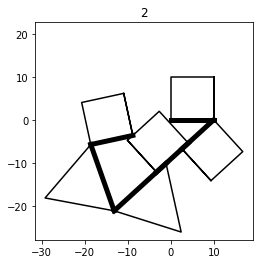

In [25]:
mc.show_final_structure(hinges, shape_arr, patch_arr, linelist, hinge_vec, final_hinges[hinges])

### Run Simulations Many Times

##### Run thecode "sims" number of times and return all of the final hinge conformations and energies

In [26]:
sims = 1000
final_hinges, final_es = mc.runrun_parallel_forward(patch_arr, shape_arr, hinge_vec, hinges, linelist, polycount, moves, std, E_ref_initial,
                                                    E_low, anneal_rate, sims, mask_arr, v_xmat, h_xmat, v_ymat, h_ymat, Ml_mat, shape_ind, patch_ind,
                                                    changes, anneal_cutoff, equilibrium_cutoff,change_overlap = True)

## Clustering Final Hinges

### If no experimental hinges for a final conformation of a structure are known:

##### Determine the appropriate number of clusters. Both the silhouette and Davies-Bouldin method for determining the optimal number of equilibrium structures are shown. The maximum silhouette score and minimum davies-bouldin score are used. If the two are different, the maximum between the two is used

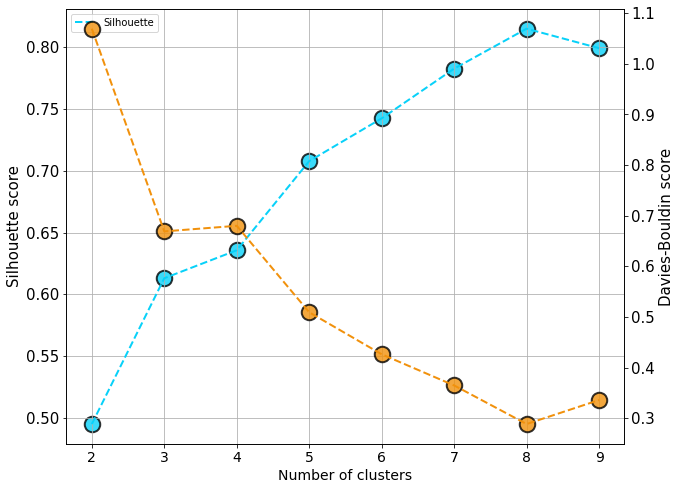

In [27]:
cluster_max = 10
states = 10 #A cluster parameter that allows the KMeans clustering to try out different initial states for better optimization
clusternumber = mc.cluster_num(final_hinges,cluster_max,states, Plot = True)

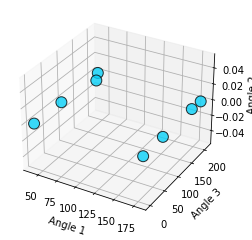

In [28]:
clustercenters, cluster_labels, clusternumber = mc.min_cluster_centers(final_hinges, clusternumber, final_es, Plots = '3D')

### If there is a known set of experimental hinges:

##### Search for clusters using the known one as an initial state

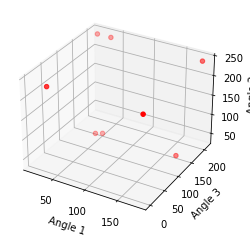

In [29]:
experimental_hinges = [15,240,210]
clustercenters_exp, cluster_labels_exp = mc.min_cluster_centers_experimental(final_hinges, clusternumber, final_es, experimental_hinges,
                                                                             Plots = '3D', max_iter=300, tol=1e-4, n_init = states)

##### Refine the clustered hingesin the event of a known experimental hinge. Angle var described an amount of built-in variance prescribed to a particular hinge. If clustered hinges are within +/- the values within angle_var, the they are reassigned as a part of that cluster

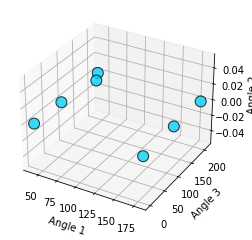

In [30]:
angle_var = np.array([5, 5, 5])
clustercenters, cluster_labels, final_hinges, final_e = mc.refine_experimental_labels(clustercenters, cluster_labels, clusternumber,
                                                                                      final_hinges, final_es, angle_var, Plots= '3D')

### Cluster Statistics

##### Determine the statistics of each cluster by counting the number of conformations in each cluster. Plot the data as a histogram

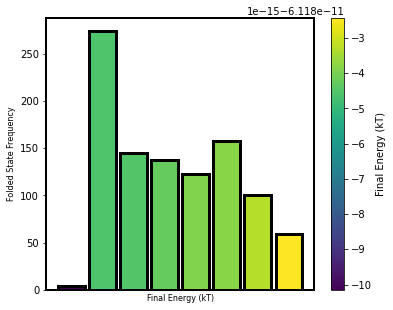

In [31]:
clusternumbers, cluster_count, cluster_prob, energies, ordered_centers, all_stds = mc.cluster_stats(final_hinges, clusternumber, clustercenters, cluster_labels,
                                                                                                    final_es, plot=True)

##### Display the folded conformation in the order the show up in the histogram from left to right

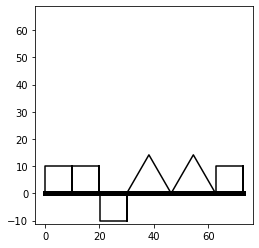

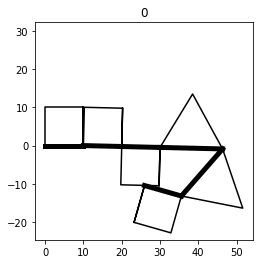

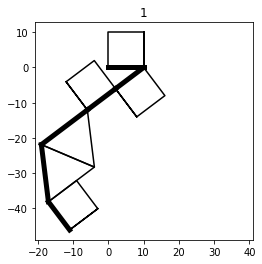

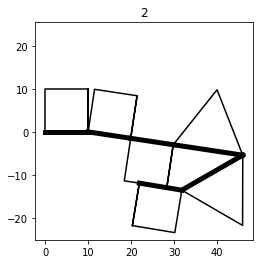

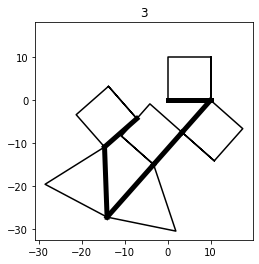

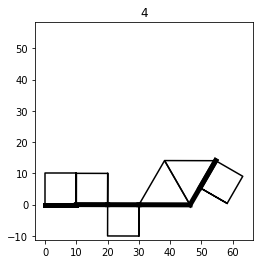

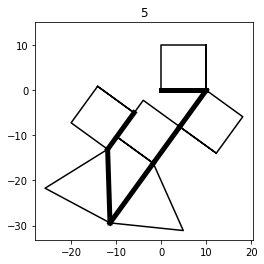

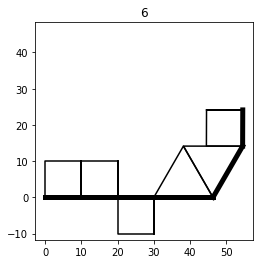

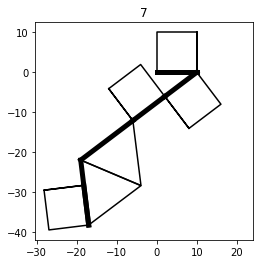

In [32]:
mc.show_probable_structures(hinges, shapes, clustercenters)

## Run and Store Data From Parallellized Simulations

##### Initialize the dictionary that will store all data from simulations

In [33]:
savedict = mc.define_savedict()

### Here are some important functions throughout the process that allow everything to run

##### This next code is not necessary here, but it is the base of the massively parallelized simulations to explore the design space. It essentially combines generation, initialization of key variables, and clustering into a signle function

In [ ]:
savedict = mc.parallellel_powerful_forward(moves, std, m, shapes, initial_angle, anneal_steps, sims, cluster_max, anneal_cutoff, equilibrium_cutoff, savedict)

##### This code  generates a random structure based on the given simulation parameters. It is best for generating random sequences of a given length for the length simulations

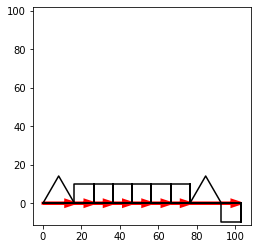

In [34]:
shape_options = ['s','t']
orientation_options = ['A','B']
len_options = [10] #length of each patch face
chain_len = 9 #Number of subunits in the sequence
shapes = mc.vary_structure(shape_options, orientation_options, len_options, chain_len)

#Display the randomly generated sequence
hinge_vec, shape_arr, sequence, linelist, patch_arr = mc.generate(shapes)
mc.shapeplots(shape_arr, linelist, mag_vecs=patch_arr)

##### This code generates random sequences with specified numbers of each shape listed in "shape options." This is most useful for generating sequences of both a given length and given numbers of each shape in order to explore the shape design space in shape design space exploration

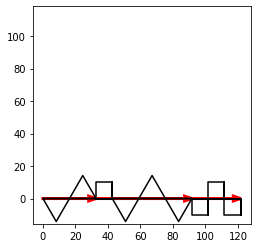

In [35]:
shape_options = ['s','t']
shape_nums = [4,5] #The number of each shape that should be included
orientation_options = ['A','B']
len_options = [10]
chain_len = 9
shapes = mc.vary_shapes(shape_options, shape_nums, orientation_options, len_options, chain_len)

#Display the randomly generated sequence
hinge_vec, shape_arr, sequence, linelist, patch_arr = mc.generate(shapes)
mc.shapeplots(shape_arr, linelist, mag_vecs=patch_arr)

##### This next code generates a random sequence given the allowed orientations and allowed chain length. It is useful for generating sequences at the start of magnetic and shape simulations. Then, the shape structure and magentic structure can be randomized while the sequence remains the same in order to better explore effects of changing shape and magnetization

In [36]:
orientation_options = ['A','B']
chain_len = 9
sequence = mc.generate_sequence(orientation_options, chain_len)
print(sequence)

['B', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'B']


##### This next code uses a sequence provided and randomizes the shapes based on the ratios given in shape_nums

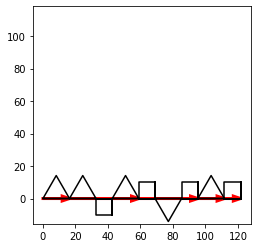

In [37]:
shape_options = ['s','t']
shape_nums = [4,5] #The number of each shape that should be included
len_options = [10]
chain_len = 9
shapes = mc.vary_only_shapes(shape_options, shape_nums, len_options, chain_len, sequence)

#Display the randomly generated sequence
hinge_vec, shape_arr, sequence, linelist, patch_arr = mc.generate(shapes)
mc.shapeplots(shape_arr, linelist, mag_vecs=patch_arr)

##### This next code uses a sequence provided and randomizes the magnetiization of each patch based on the relastive strength defined in strength_percent which are relative magnetization strength relative to mval. Patch_nums then defines how many of shapes of each relative patch strength are generated

In [38]:
strength_percent = [0.5, 1] #Relative strength of each patch in terms of mval
patch_nums = [5,4] #The number of shapes with each patch strength to include
chain_len = 9
mval = 1.01e-6 #The absolute magnetization/length of the shapes
m = mc. vary_m(strength_percent, patch_nums, chain_len, mval)
print(m)

[1.01e-06, 5.05e-07, 5.05e-07, 1.01e-06, 5.05e-07, 1.01e-06, 1.01e-06, 5.05e-07, 5.05e-07]


### Run simulations exploring different parameters, generating random sequences shapes and magnetizations in a systematic way to explore the effects of different parameters. In this example code, the number of generated sequences will remian extremely small for the sake of time in writing this. Keep in mind that at least 200 replicates are needed for each criteria, though more is prefarred. It is advised to parallelize this code over ~20 processors for maximum efficiency. Even still, simulations can take a very long time, so it is advised to run code in segments that can be saved and later recombined

##### This code is run first to generate a dataframe in which to store all of the data in a format that can then be easily saved

In [39]:
l_sims = 2 #number of replicates simulations for each length
l_number_options = [4,5] #The lengths of sequences to be generated. In this particular example, 2 sequences will be generated with 4 subunits, followed by 2 with 5 subunits
s_sims = 2 #number of replicates simulations for each number of triangles tested in sequences of a given length
s_number_options = [4,5] #The numbers of a given shape to be included within a sequence to be tested. In this example, 2 sequences will be generated that contain 4 triangles, and
                         #2 will be generated with 5 triangles
m_sims = 2 #number of replicates simulations for each number of magnetizations tested in sequences of a given length
m_number_options = [4,5] #The numbers of a given magnetization to be included within a sequence to be tested. In this example, 2 sequences will be generated that contain 4
                         #patches  of a defined strength, and 2 will be generated with 5 patches of a defined strength
mainframe, indexlist = mc.define_mainframe(l_sims, l_number_options, s_sims, s_number_options, m_sims,  m_number_options)
print(mainframe.to_markdown())

|             |   shapes |   length |   magnetization |   initial angle |   std |   E_ref |   E_low |   anneal steps |   hinge number |   hinges |   % triangles |   patch strengths |   patch numbers |   final hinges |   probability |   energies |   hinge stds |   clusternumber |   anneal cutoff |   equilibrium cutoff |
|:------------|---------:|---------:|----------------:|----------------:|------:|--------:|--------:|---------------:|---------------:|---------:|--------------:|------------------:|----------------:|---------------:|--------------:|-----------:|-------------:|----------------:|----------------:|---------------------:|
| Sequence 1  |      nan |      nan |             nan |             nan |   nan |     nan |     nan |            nan |            nan |      nan |           nan |               nan |             nan |            nan |           nan |        nan |          nan |             nan |             nan |                  nan |
| Sequence 2  |      nan |      nan |

##### This code runs only the length simulations defined above. It is generating 2 random sequences for each of the defined lengths, running the MC simulation sims times for each one, performing clustering analysis and recording the data in mainframe. This mainframe can then be passed on to other functions.

In [40]:
count = 0
mainframe, count = mc.megasim_varylength(moves, std, mval, initial_angle, anneal_steps, l_sims, sims, cluster_max, l_number_options, shape_options,
                                         orientation_options, len_options, indexlist, mainframe, savedict, count, anneal_cutoff, equilibrium_cutoff)

Simulating Chains of Length 4

Simulation #0


Simulation #1
Simulating Chains of Length 5

Simulation #0
Simulation #1


##### Display the mainframe after running length simulations

In [42]:
print(mainframe.to_markdown())

|             | shapes                                                                                                                                  |   length | magnetization                                      |   initial angle |   std |         E_ref |         E_low |   anneal steps |   hinge number | hinges    |   % triangles |   patch strengths |   patch numbers | final hinges                                     | probability                                             | energies                                                          | hinge stds                              |   clusternumber |   anneal cutoff |   equilibrium cutoff |
|:------------|:----------------------------------------------------------------------------------------------------------------------------------------|---------:|:---------------------------------------------------|----------------:|------:|--------------:|--------------:|---------------:|---------------:|:----------|--------------:|---------

##### This code runs the shape simulations for chains of a given length. With a defined length, the code first generates all of the sequences it will use (only orientation and length data contained). During the simulations, it randomizes their structure by placing the specified amounts of each shape into the sequence.

In [64]:
shape_options = ['s','t']
mainframe, count = mc.megasim_varyonlyshapes(moves, std, mval, initial_angle, anneal_steps, s_sims, sims, cluster_max, chain_len, shape_options, orientation_options,
                                             len_options, s_number_options, indexlist, mainframe, savedict, count, anneal_cutoff, equilibrium_cutoff)
print(mainframe.to_markdown())

Simulating Sequences with 4 Triangles

Simulation # 0
Simulation # 1
Simulating Sequences with 5 Triangles

Simulation # 0
Simulation # 1
|             | shapes                                                                                                                                                                                                                                              |   length | magnetization                                                                              |   initial angle |   std |         E_ref |         E_low |   anneal steps |   hinge number | hinges       |   % triangles |   patch strengths |   patch numbers | final hinges                                            | probability                                             | energies                                                          | hinge stds                                          |   clusternumber |   anneal cutoff |   equilibrium cutoff |
|:------------|:----------------------

##### This code runs the magnetization simulations for chains of a given length. With a defined length, the code first generates all of the sequences it will use (only orientation and length data contained). During the simulations, it randomizes their magnetizations by placing the specified amounts of each magnetization into the sequence.

In [65]:
strength_percents = [0.5,1]  #Allowed relative magent strengths
mainframe, count = mc.megasim_varyonlypatch(moves, std, mval, initial_angle, anneal_steps, m_sims, sims, cluster_max, chain_len, shape_options, orientation_options,
                                            len_options, strength_percents, m_number_options, indexlist, mainframe, savedict, count, anneal_cutoff, equilibrium_cutoff)
print(mainframe.to_markdown())

Simulating Sequences with 4 patches of 50.0 % strength

Simulation # 0


NameError: name 're' is not defined

### This next code utilizes a function that goes through all simulation types. By definiting an input dictionary, all relevant parameters are supplied with ease

##### Define input dictionary. Hereis the setup for a simulation using the standard values for global parameters that studies some relevant subsets of the design space.

In [43]:
moves  = 1000
std = 10
mval = 1.01e-6
initial_angle = 30
anneal_steps = 100
r_sims = 1000
cluster_max = 10
chain_len = 10 #Default chain length
anneal_cutoff = 50
equilibrium_cutoff = 75

l_sims = 200
l_number_options = [10,11,12,13,14,15]
l_shape_options = ['s']
l_orientation_options = ['A','B']
l_len_options = [10]

s_sims =  200
s_shape_options = ['s','t']
s_orientation_options = ['A','B']
s_len_options = [10]
s_number_options = [0,1,2,3,4,5,6,7,8,9,10]

m_sims =  200
m_shape_options = ['s']
m_orientation_options = ['A','B']
m_len_options = [10]
m_strength_percents= [0.5,1]
m_number_options = [0,1,2,3,4,5,6,7,8,9,10]

input_dict = mc.define_input_dict(moves, std, mval, initial_angle, anneal_steps, r_sims, cluster_max, chain_len, anneal_cutoff, equilibrium_cutoff,
                                  l_sims, l_number_options, l_shape_options, l_orientation_options, l_len_options,
                                  s_sims, s_shape_options, s_orientation_options, s_len_options, s_number_options,
                                  m_sims, m_shape_options, m_orientation_options, m_len_options, m_strength_percents, m_number_options)

##### Run the simulations with the specified values. Note, this will take an extremely long timne to run. Consider editing values to explore smaller subsets of the dataspace at a given time

In [ ]:
mainframe = mc.run_all_magasims_varyonlyshape(input_dict)

##### save the mainframe as a csv in the current working directory

In [ ]:
filename = mc.save_mainframe(mainframe,'name')

### Running as a python file (.py)

##### We strongly recommend running the megasims code in a python file rather than this jupyter notebook for much faster runtimes. In  this case, please use the code supplied below in a file in the same working directory as the Monte Carlo Functions

In [ ]:
import MC_Tutorial_Functions as mc

if __name__ == '__main__':
    
    moves  = 1000
    std = 10
    mval = 1.01e-6
    initial_angle = 30
    anneal_steps = 100
    r_sims = 1000
    cluster_max = 10
    chain_len = 10 #Default chain length
    anneal_cutoff = 50
    equilibrium_cutoff = 75

    l_sims = 200
    l_number_options = [10,11,12,13,14,15]
    l_shape_options = ['s']
    l_orientation_options = ['A','B']
    l_len_options = [10]

    s_sims =  200
    s_shape_options = ['s','t']
    s_orientation_options = ['A','B']
    s_len_options = [10]
    s_number_options = [0,1,2,3,4,5,6,7,8,9,10]

    m_sims =  200
    m_shape_options = ['s']
    m_orientation_options = ['A','B']
    m_len_options = [10]
    m_strength_percents= [0.5,1]
    m_number_options = [0,1,2,3,4,5,6,7,8,9,10]

    input_dict = mc.define_input_dict(moves, std, mval, initial_angle, anneal_steps, r_sims, cluster_max, chain_len, anneal_cutoff, equilibrium_cutoff,
                                      l_sims, l_number_options, l_shape_options, l_orientation_options, l_len_options,
                                      s_sims, s_shape_options, s_orientation_options, s_len_options, s_number_options,
                                      m_sims, m_shape_options, m_orientation_options, m_len_options, m_strength_percents, m_number_options)
    
    mainframe = mc.run_all_magasims_varyonlyshape(input_dict)

    filename = mc.save_mainframe(mainframe, "filename")

### Varying Shape and Length Simultaneously

##### The below code is intended to run simulations that simulataneously vary teh length and shape of a sequence.  That is, for each given sequence length, it runs simulations replacing shapes in the sequence, going from no triangles, to all triangles. This helps to more fully map the design space for all possible combinations

##### The function can be used on its own

In [ ]:
number_options = [8,9,10,11,12,13,14]
shape_percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mainframe, count = mc.megasim_varylength_withshapes(moves, std, mval, initial_angle, anneal_steps, l_sims, r_sims, cluster_max, number_options, shape_options,
                                                    shape_percent, orientation_options, len_options, indexlist, mainframe, savedict, count, anneal_cutoff, equilibrium_cutoff)

##### Define the input dictionary that goes with the simulataneous length and shape simulations

In [44]:
moves  = 1000
std = 10
mval = 1.01e-6
initial_angle = 30
anneal_steps = 100
r_sims = 1000
cluster_max = 10
chain_len = 10 #Default chain length
anneal_cutoff = 50
equilibrium_cutoff = 75

l_sims = 200
l_number_options = [10,11,12,13,14,15]
l_shape_options = ['s','t']
l_shape_percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l_orientation_options = ['A','B']
l_len_options = [10]

s_sims =  200
s_shape_options = ['s','t']
s_orientation_options = ['A','B']
s_len_options = [10]
s_number_options = [0,1,2,3,4,5,6,7,8,9,10]

m_sims =  200
m_shape_options = ['s']
m_orientation_options = ['A','B']
m_len_options = [10]
m_strength_percents= [0.5,1]
m_number_options = [0,1,2,3,4,5,6,7,8,9,10]

input_dict = mc.define_input_dict_ls(moves, std, mval, initial_angle, anneal_steps, r_sims, cluster_max, chain_len, anneal_cutoff, equilibrium_cutoff,
                                     l_sims, l_number_options, l_shape_options, l_shape_percent, l_orientation_options, l_len_options,
                                     s_sims, s_shape_options, s_orientation_options, s_len_options, s_number_options,
                                     m_sims, m_shape_options, m_orientation_options, m_len_options, m_strength_percents, m_number_options)

##### run all of the simulations

In [ ]:
mainframe = mc.run_all_magasims_ls(input_dict)

##### again, it is preferrable to run all simulations in a python script rather than a jupyter notebook. Here is that code

In [ ]:
import MC_Tutorial_Functions as mc

if __name__ == '__main__':
    
    moves  = 1000
    std = 10
    mval = 1.01e-6
    initial_angle = 30
    anneal_steps = 100
    r_sims = 1000
    cluster_max = 10
    chain_len = 10 #Default chain length
    anneal_cutoff = 50
    equilibrium_cutoff = 75

    l_sims = 200
    l_number_options = [10,11,12,13,14,15]
    l_shape_options = ['s','t']
    l_shape_percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    l_orientation_options = ['A','B']
    l_len_options = [10]

    s_sims =  200
    s_shape_options = ['s','t']
    s_orientation_options = ['A','B']
    s_len_options = [10]
    s_number_options = [0,1,2,3,4,5,6,7,8,9,10]

    m_sims =  200
    m_shape_options = ['s']
    m_orientation_options = ['A','B']
    m_len_options = [10]
    m_strength_percents= [0.5,1]
    m_number_options = [0,1,2,3,4,5,6,7,8,9,10]


    input_dict = mc.define_input_dict_ls(moves, std, mval, initial_angle, anneal_steps, r_sims, cluster_max, chain_len, anneal_cutoff, equilibrium_cutoff,
                                        l_sims, l_number_options, l_shape_options, l_shape_percent, l_orientation_options, l_len_options,
                                        s_sims, s_shape_options, s_orientation_options, s_len_options, s_number_options,
                                        m_sims, m_shape_options, m_orientation_options, m_len_options, m_strength_percents, m_number_options)
    
    mainframe = mc.run_all_magasims_ls(input_dict)

    filename = mc.save_mainframe(mainframe, "filename")

## Data Analysis

### Work through the symmetry, end-to-end distance,  radius of gyration, and tortuosity calculations with a single known sample before applying it to all in a dataframe. 
### Note: this is not necessary for analysis, but  is a helpful illustration of how they are done

##### Run same MC simulations as before to capture all data for a sequence for illustrative examples of the calculations

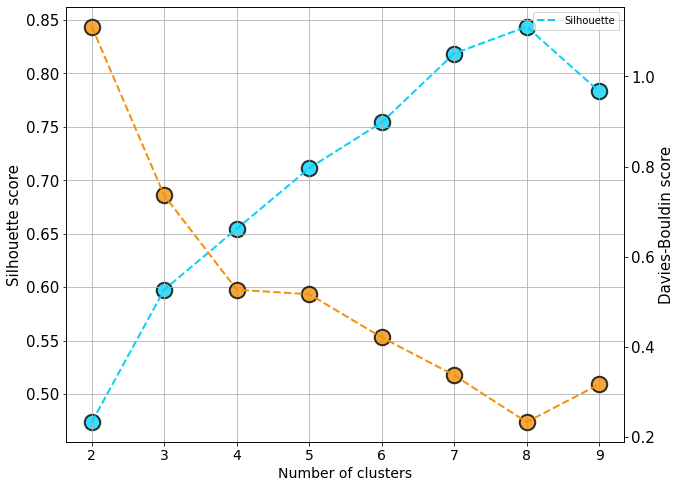

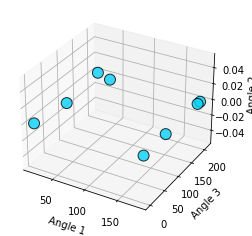

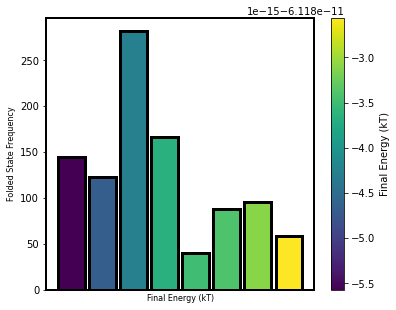

In [45]:
shapes = {'shape 1':['s','B',10],'shape 2':['s','B',10],'shape 3':['s','A',10],'shape 4':['t','B',10],'shape 5':['t','B',10],'shape 6':['s','B',10]}
hinge_vec, shape_arr, sequence, linelist, patch_arr = mc.generate(shapes)
hinges = mc.moving_hinges(sequence) #Determine which indices in hinge_vec correspond to hinges
nonhinges = mc.not_hinges(hinge_vec,hinges) #Determine which indices in hinge_vec correspond to rigid junctions
shape_ind, patch_ind, changes = mc. moving_indices(shape_arr, patch_arr, linelist, nonhinges, hinges) #Determine the indices in shape_arr and patch_arr that correspond
                                                                                                      #to rigid junctions

polycount = mc.count_shapes(shape_arr)
m = [1.01e-6]*len(sequence)
magvec = mc.mag_vectors(sequence, m)
mask_arr, v_xmat, h_xmat, v_ymat, h_ymat, Ml_mat = mc.initialize_energy(magvec)

std = 10
initial_angle = 30
E_refs, E_lows = mc.characteristic_energy(std, sequence, patch_arr, shape_arr, hinge_vec, linelist, polycount,
                                         initial_angle, mask_arr, v_xmat, h_xmat, v_ymat, h_ymat, Ml_mat)
E_ref_initial = np.mean(E_refs)
E_low = np.mean(E_lows)
moves = 1000 #Number of moves after which to prematurely terminate simulation
anneal_steps = 100 #Hop many MC steps the annealing should take place over
anneal_rate = E_ref_initial/anneal_steps #Rate at which annealing takes place
anneal_cutoff = 50  #Number of rejected steps after which to stop the annealing phase
equilibrium_cutoff = 75 #Number of rejected steps after which to end the simulation
change_overlap = True #Change the overlap each time the simulation is run

sims = 1000
final_hinges, final_es = mc.runrun_parallel_forward(patch_arr, shape_arr, hinge_vec, hinges, linelist, polycount, moves, std, E_ref_initial,
                                                    E_low, anneal_rate, sims, mask_arr, v_xmat, h_xmat, v_ymat, h_ymat, Ml_mat, shape_ind, patch_ind,
                                                    changes, anneal_cutoff, equilibrium_cutoff,change_overlap = True)

cluster_max = 10
states = 10 #A cluster parameter that allows the KMeans clustering to try out different initial states for better optimization
clusternumber = mc.cluster_num(final_hinges,cluster_max,states, Plot = True)
clustercenters, cluster_labels, clusternumber = mc.min_cluster_centers(final_hinges, clusternumber, final_es, Plots = '3D')
clusternumbers, cluster_count, cluster_prob, energies, ordered_centers, all_stds = mc.cluster_stats(final_hinges, clusternumber, clustercenters, cluster_labels,
                                                                                                    final_e, plot=True)

##### Calculate the end-to-end distance as well as the change in end-to-end distance from initial to final state

In [46]:
e2e_vec = mc.end_to_end_number_norm(ordered_centers, patch_arr, shape_arr, hinge_vec, linelist, hinges)
delta_e2e_vec = mc.delta_end_to_end_number_norm(ordered_centers, patch_arr, shape_arr, hinge_vec, linelist, hinges)
print(e2e_vec)
print(delta_e2e_vec)

[30.07613528  6.82482265  7.04286712 42.26067662 25.49855967 26.07464355
 59.75878498 49.86363394]
[42.60872796 65.86004059 65.64199612 30.42418662 47.18630357 46.61021969
 12.92607825 22.8212293 ]


##### Calculate the radius of Gyration and the change in the radius of gyration from initial to folded state. Rg is normalized by the number of shapes in the sequence and delta Rg is normalized by the initial Radius of gyration

In [47]:
Rg_vec = mc.find_Rg_number_norm(ordered_centers, patch_arr, shape_arr, hinge_vec, linelist, hinges)
delta_Rg_vec = mc.delta_Rg(ordered_centers,patch_arr,shape_arr,hinge_vec,linelist,hinges)
print(Rg_vec)
print(delta_Rg_vec)

[4.40876274 3.63267233 3.63000497 4.33174488 3.96227541 3.9968407
 4.65211271 4.79355011]
[0.21911109 0.35657378 0.35704623 0.23275265 0.29819382 0.29207155
 0.17600845 0.15095678]


##### Calculate the Tortuosity for a sequence

In [48]:
T_vec = mc.find_tortuosity(ordered_centers, patch_arr, shape_arr, hinge_vec, linelist, hinges, shapes)
print(T_vec)

[0.06025166 0.11432952 0.11893194 0.08312462 0.10594933 0.11448243
 0.08266032 0.05965411]


##### Calculate the symmetry score for each of the folded configurations

In [49]:
sym_vec = mc.find_symmetry(ordered_centers,patch_arr,shape_arr,hinge_vec,linelist,hinges)
print(sym_vec)

[0.79059117 0.8726844  0.8726844  0.91351267 0.8726844  0.8726844
 0.9153478  0.75283454]


##### For any given measurable parameter (Radius of gyration, tortuosity, etc.) use the frequency of each folded conformation appearing to weight the values of that measurable to obtain a single average value as well as a weighted standard deviation

In [50]:
av_sym, std_sym = mc.weighted_avg_and_std(sym_vec, cluster_prob)
print(av_sym)
print(std_sym)

0.8646237485397369
0.04704057576045244


### Now the entire save mainframe can be analyzed using these functions while also making use of parallelization

##### Load mainframe from files. The file 'tutorial_subset.csv' is provided in the attached code to use as an example

In [51]:
path = os.getcwd()
filename = path + '/tutorial_subset.csv'
mainframe = mc.load_mainframe(filename)

##### Once all of the data is loaded in, this next function calculates all measurables and their averages for every sequence based on the clustering analysis. The output is a dataframe containing the original information along with all of the calculated information. For speed purposes, we recommend running the code in a .py python notebook rather than a jupyter notebook. Both sets of code are included here

In [ ]:
row_min = 0
row_max = len(mainframe)
analyzed_mainframe = mc.analyze_dataset_numbernorm(mainframe, row_min, row_max)
title = 'analyzed_tutorial_subset'
analyzed_mainframe = mc.save_mainframe(analyzed_mainframe,title)

##### We recommend using this next code in a python script for more efficient data analysis. Processing times may vary based on the size of the dataset and the number of processors allocated to the parallellized calculations.

In [ ]:
import MC_Tutorial_Functions as mc
import os

if __name__ == '__main__':

    path = os.getcwd()
    filename = path + '/tutorial_subset.csv'
    mainframe = mc.load_mainframe(filename)

    row_min = 0
    row_max = len(mainframe)
    analyzed_mainframe = mc.analyze_dataset_numbernorm(mainframe, row_min, row_max)
    title = 'analyzed_tutorial_subset'
    analyzed_mainframe = mc.save_mainframe(analyzed_mainframe,title)

## Chain Length Analysis

##### Load in the analyzed data. This has to be done by combining the data from two pandas dataframes (one dataframe is too large for a github post)

In [ ]:
path = os.getcwd()

filename = path + '/analyzed_tutorial_subset_upper_half.csv'
top_frame = mc.load_mainframe(filename)
filename = path + '/analyzed_tutorial_subset_bottom_half.csv'
bottom_frame = mc.load_mainframe(filename)
analyzed_mainframe = pd.concat([top_frame,bottom_frame])

##### Look at data containing powers of 2 first to find the exponential fit

In [3]:
length_list = [8,16,32,64]
param_list = copy.deepcopy(analyzed_mainframe.loc[:, 'avg e2e':'avg symmetry'].columns.tolist())
hinges = np.array(analyzed_mainframe.loc[:,'hinge number'])
hinge_list = sorted(list(set(hinges)))

##### Determine an average value for each measurable over all sequences of a given length. Additionally, determine the standard deviation based on the distribution for each parameter

In [4]:
av_df, std_df = mc.length_analysis(analyzed_mainframe, length_list, param_list)
print(av_df.to_markdown())

|    |   length |   hinges |     e2e |     de2e |       Rg |      dRg |   tortuosity |   symmetry |
|---:|---------:|---------:|--------:|---------:|---------:|---------:|-------------:|-----------:|
|  0 |        8 |      nan | 34.0851 |  45.9499 |  26.2815 | 0.239673 |    0.0877799 |   0.929305 |
|  1 |       16 |      nan | 28.7877 | 131.287  |  39.5947 | 0.403173 |    0.0787308 |   0.954224 |
|  2 |       32 |      nan | 11.3549 | 308.8    |  64.8843 | 0.505485 |    0.0723296 |   0.970503 |
|  3 |       64 |      nan | 11.2845 | 629.03   | 112.101  | 0.571582 |    0.069589  |   0.973452 |


##### Next, plot the data on a log-log plot and fit a line with slope 3/4 to it- save these parameters. Additionally, convert to an exponential function and plot with raw data.Finally, plot the Rg vs sequence length to the 3/4 power

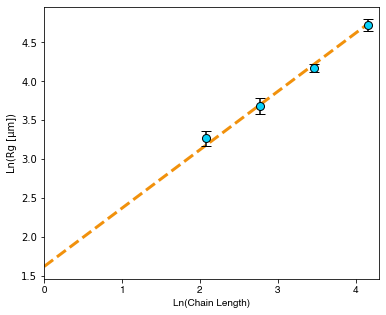

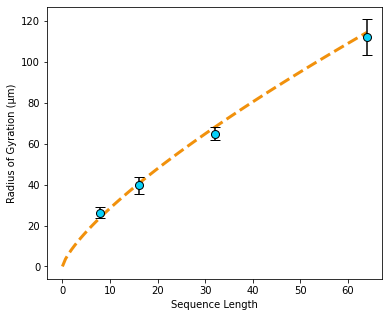

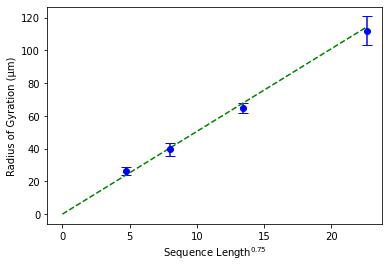

In [5]:
log_slope, log_intercept, residuals = mc.fit_length_data(av_df, std_df, length_list, log_slope = 3/4)

##### Now, determine the different numbers of hingess. Perform the length_analysis  while also filtering by number of hinges

In [6]:
length_list = sorted(list(set(analyzed_mainframe.loc[:,'length'])))[:-1]
param_list = copy.deepcopy(analyzed_mainframe.loc[:, 'avg e2e':'avg symmetry'].columns.tolist())
hinges = np.array(analyzed_mainframe.loc[:,'hinge number'])
hinge_list = sorted(list(set(hinges)))
av_df_h, std_df_h = mc.length_analysis(analyzed_mainframe, length_list, param_list, hinge_list)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/nump

##### Normalize the radius of gyration by the formula $\text{Normalized Rg} = \frac{\text{Rg}}{log intercept \cdot \text{length}^{3/4}}$ and plot the results along with the standard deviation.

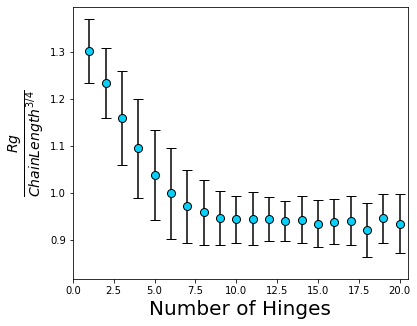

In [7]:
condensed_arr, stds = mc.normRg_vs_hinges(analyzed_mainframe, log_intercept, log_slope, lengths=length_list, show=True)

##### Determine the appropriate polynomial fit for the data plotted above. Polynomial of degree 4 works best

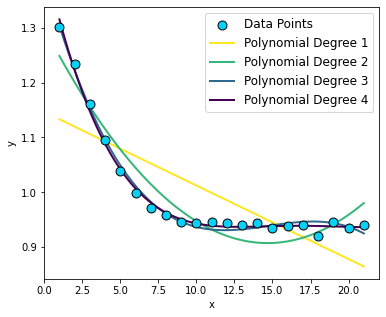

In [8]:
fits = mc.find_degree_fit(condensed_arr)

##### fit the data to a polynomial of degree 4 and scale the data by this polynomial

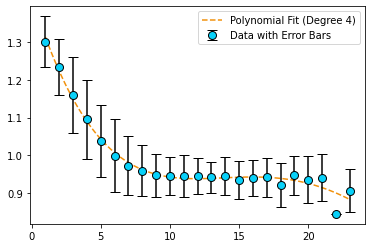

In [9]:
fit, scaled_df, scaled_stds = mc.fitandscaledata(condensed_arr, stds, 4)

## Triangles Analysis

##### Triangles have a different length than cubes, so the analysis won't just work by number of subunits anymore- it has to be normalized by the length of the entire chain. Perform the previous fitting analysisusing the total chain length

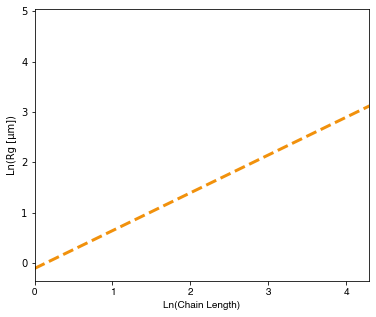

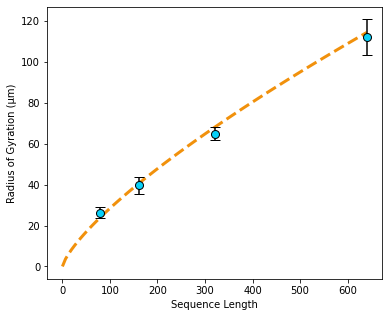

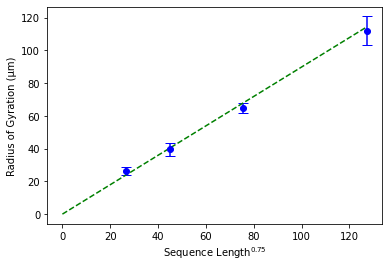

In [10]:
length_list = [8,16,32,64]
av_df, std_df = mc.length_analysis(analyzed_mainframe, length_list, param_list)
total_length_list = (av_df.loc[:,'e2e'] + av_df.loc[:,'de2e']).to_numpy()
log_slope_s, log_intercept_s, residuals = mc.fit_length_data(av_df, std_df, total_length_list, log_slope = 0.75)

##### Take avarages, separating out hinges

In [11]:
length_list = sorted(list(set(analyzed_mainframe.loc[:,'length'])))[:-1]
param_list = copy.deepcopy(analyzed_mainframe.loc[:, 'avg e2e':'avg symmetry'].columns.tolist())
hinges = np.array(analyzed_mainframe.loc[:,'hinge number'])
hinge_list = sorted(list(set(hinges)))
av_df, std_df = mc.length_analysis(analyzed_mainframe, length_list, param_list, hinge_list)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/nump

##### Find the degree fit and scale the data to the fit

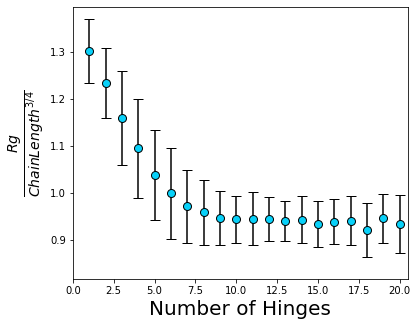

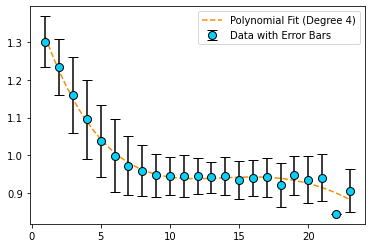

In [12]:
lengths = sorted(list(set(analyzed_mainframe.loc[:,'length'])))[:-1]
condensed_arr, stds = mc.normRg_vs_hinges(analyzed_mainframe, log_intercept_s, log_slope_s, lengths = lengths, total_length=True)
degree = 4
fit_s, scaled_df, scaled_std_df = mc.fitandscaledata(condensed_arr,stds,degree)

##### Now that hinge and length fits are prepared, triangle data can be analyzed and scaled by this.
##### Start by loading in triangle data

In [14]:
title = "analyzed_ssims_10_4G"
path = os.getcwd() #Identify the filepath
filename = os.path.join(path, title + ".csv")
analyzed_mainframe = mc.load_mainframe(filename)

##### Take dataset averages over each triangle percentage and each number of hinges within that triangle percentage

In [14]:
shape_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1] #Triangle Percentages
param_list = copy.deepcopy(analyzed_mainframe.loc[:, 'avg e2e':'avg symmetry'].columns.tolist())
hinges = np.array(analyzed_mainframe.loc[:,'hinge number'])
hinge_list = sorted(list(set(hinges)))
av_df_s, std_df_s, sterr_df_s = mc.simultaneous_scaling_shape_analysis(analyzed_mainframe, shape_list, param_list, log_intercept_s, log_slope_s, fit_s, hinge_list)

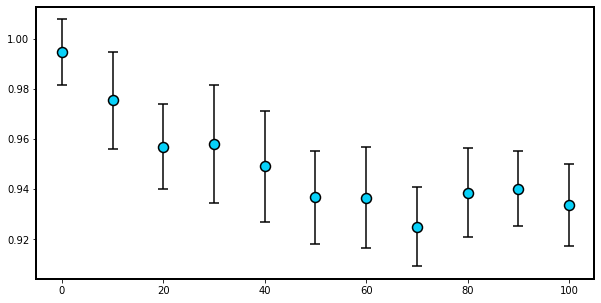

In [15]:
plot_arr, condensed_arr = mc.lengthhingenormRg_vs_triangles(av_df_s, std_df_s, shape_list, sterr_df_s)

## Magnetization Analysis

##### Load in all of the analyzed magnetic patch data

In [16]:
title = "analyzed_msims_10_3G"
path = os.getcwd()
filename = os.path.join(path, title + ".csv")
analyzed_mainframe_50 = mc.load_mainframe(filename)

title = "analyzed_msims_0.1_10_4G"
path = os.getcwd()
filename = os.path.join(path, title + ".csv")
analyzed_mainframe_10 = mc.load_mainframe(filename)

title = "analyzed_msims_.1x2_10_4G"
path = os.getcwd()
filename = os.path.join(path, title + ".csv")
analyzed_mainframe_10x2 = mc.load_mainframe(filename)

analyzed_mainframe_10 = pd.concat([analyzed_mainframe_10,analyzed_mainframe_10x2])

title = "analyzed_msims_.25_10_4G"
path = os.getcwd()
filename = os.path.join(path, title + ".csv")
analyzed_mainframe_25 = mc.load_mainframe(filename)

##### take averages across patch percents and number of hinges simultaneously

In [17]:
av_df_10, std_df_10, sterr_df_10, patches_list_10 = mc.analyze_patches(analyzed_mainframe_10, param_list, log_intercept, log_slope, fit)
av_df_25, std_df_25, sterr_df_25, patches_list_25 = mc.analyze_patches(analyzed_mainframe_25, param_list, log_intercept, log_slope, fit)
av_df_50, std_df_50, sterr_df_50, patches_list_50 = mc.analyze_patches(analyzed_mainframe_50, param_list, log_intercept, log_slope, fit)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/nump

##### Plot each one independently

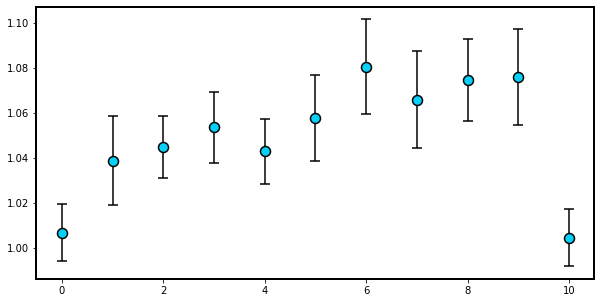

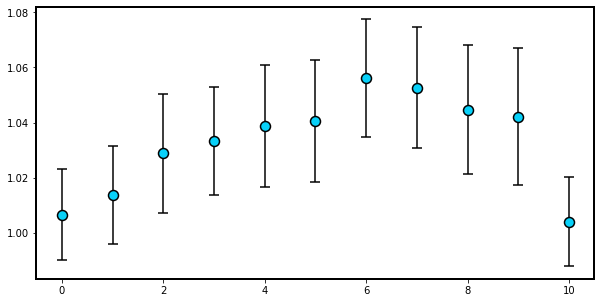

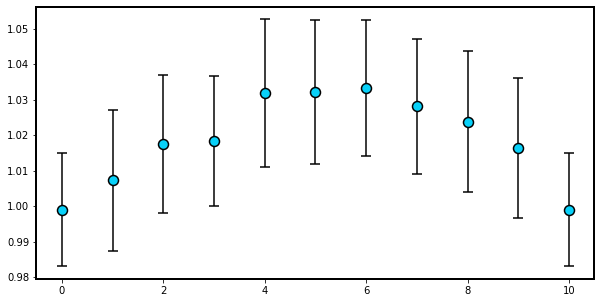

In [18]:
plot_arr_10, condensed_arr_10 = mc.lengthhingenormRg_vs_weakmags(av_df_10, std_df_10, sterr_df_10, patches_list_10)
plot_arr_25, condensed_arr_25 = mc.lengthhingenormRg_vs_weakmags(av_df_25, std_df_25, sterr_df_25, patches_list_25)
plot_arr_50, condensed_arr_50 = mc.lengthhingenormRg_vs_weakmags(av_df_50, std_df_50, sterr_df_50, patches_list_50)

##### Plot them all together

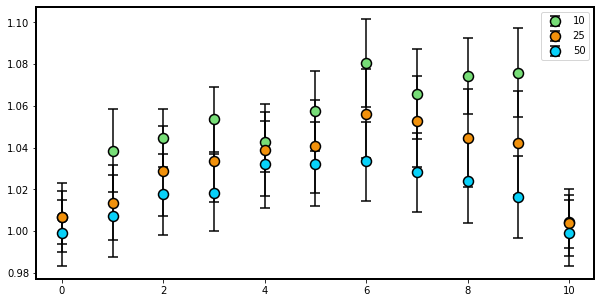

In [19]:
mag_dict = {'10':condensed_arr_10,'25':condensed_arr_25,'50':condensed_arr_50}
mc.plot_mags(mag_dict)

## Radius of Gyration Data

##### Load in the analyzed data, then filter out unwanted lengths. In this case, filter out sequences of length 64 since there are not lengths in between 32 and 64

In [20]:
path = os.getcwd()
filename = path + '/analyzed_tutorial_subset.csv'
df_squares = mc.load_mainframe(filename)
length_list = sorted(list(set(df_squares.loc[:,'length'])))[:-1]
filtered_length= mc.filter_df(length_list,df_squares)

##### Plot this histogram- this is being done with the sample data provided, which is a subset of all the data collected. For more expansive results, all data should be combined and used

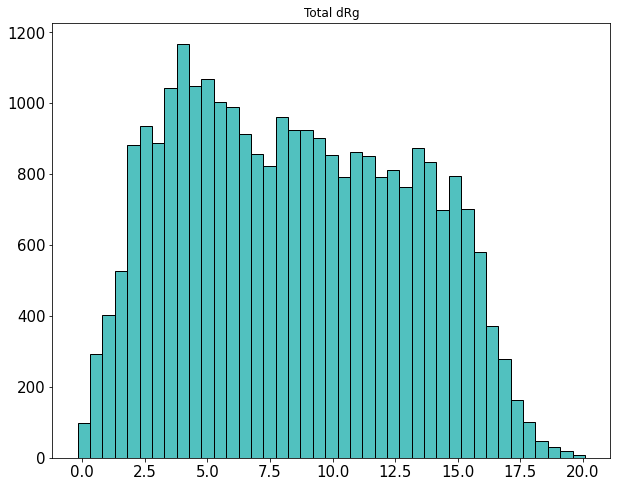

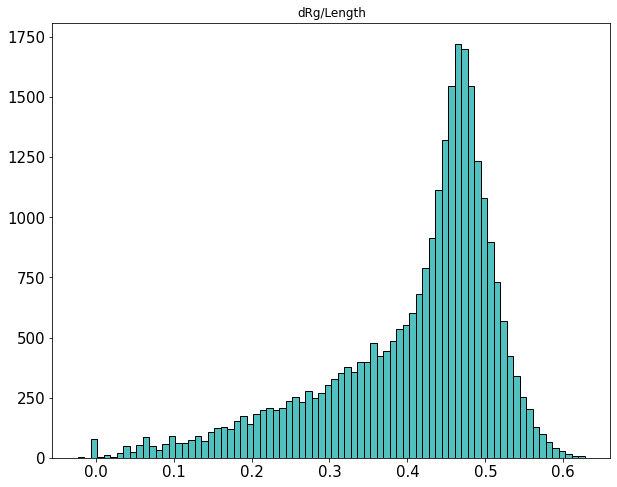

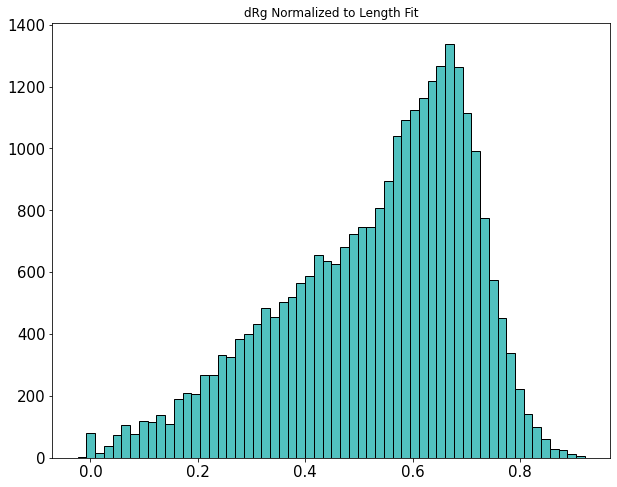

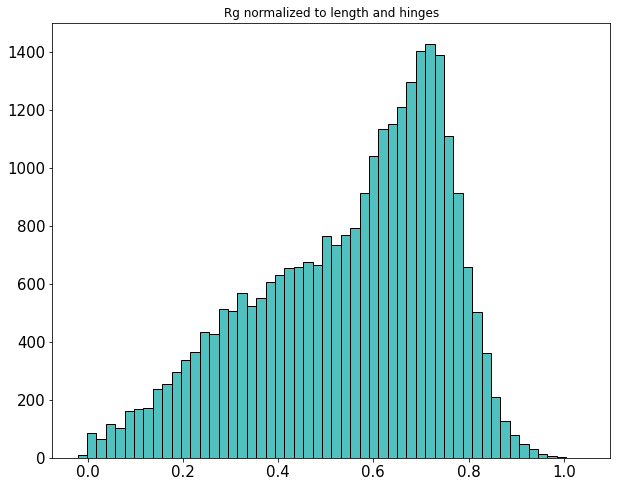

In [21]:
mc.Rg_histograms(filtered_length,log_slope,log_intercept,fit)

##### Add the triangle data, as well

In [24]:
path = os.getcwd()

filename_shapes_10 = path + '/analyzed_ssims_10_4G.csv'
df_shapes_10 = pd.read_csv(filename_shapes_10,index_col = 0)

filename_shapes_20 = path + '/analyzed_ssims_20_evens_4G.csv'
df_shapes_20 = pd.read_csv(filename_shapes_20,index_col = 0)

##### Combine triangle data with cube data

In [25]:
analyzed_mainframe = pd.concat([df_squares,df_shapes_10,df_shapes_20])
analyzed_mainframe.reset_index(drop=True, inplace=True)
analyzed_mainframe.index = analyzed_mainframe.index.map(lambda x: f'Sequence {x + 1}')
analyzed_mainframe = analyzed_mainframe.applymap(mc.deserialize_complex_data)
length_list = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
filtered_length_t= mc.filter_df(length_list,analyzed_mainframe)

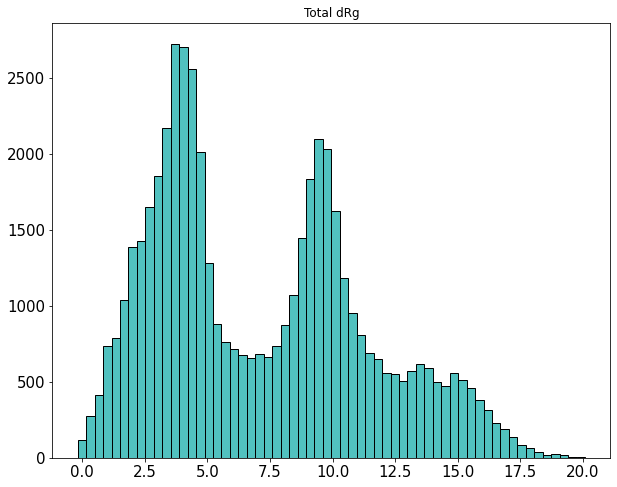

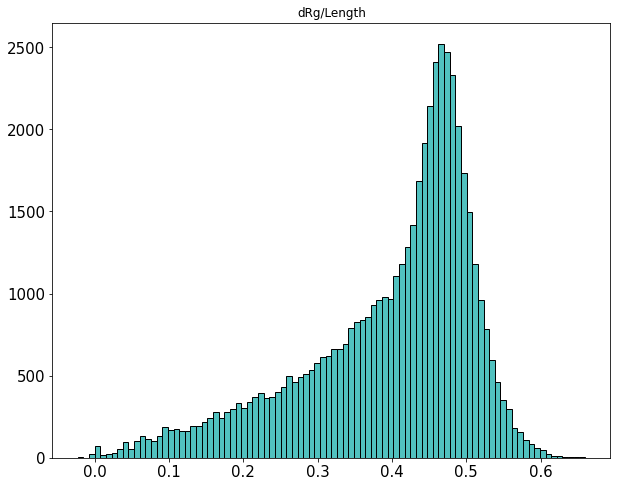

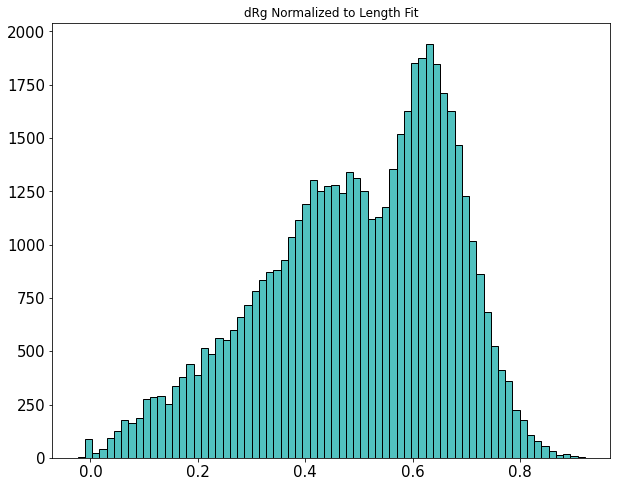

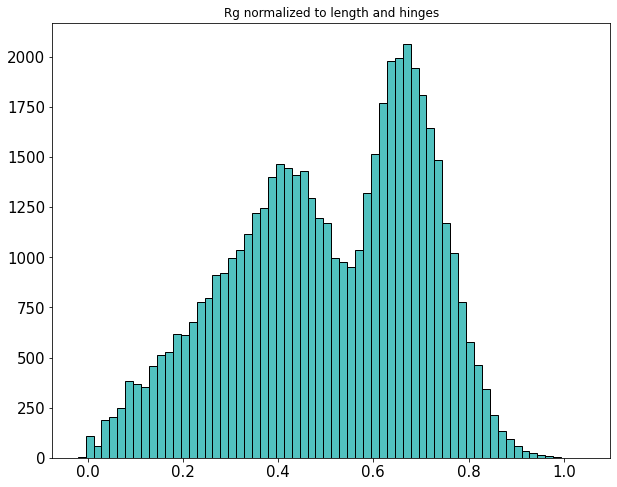

In [26]:
mc.Rg_histograms(filtered_length_t,log_slope,log_intercept,fit)

##### Display structures that exhibit Rg values within a particular range. Can easily modify to show the highest or lowest dRg scores

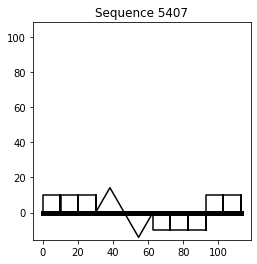

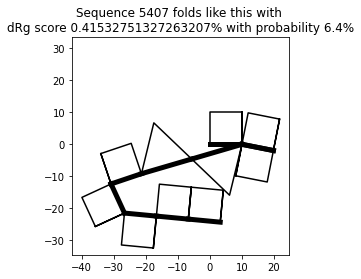

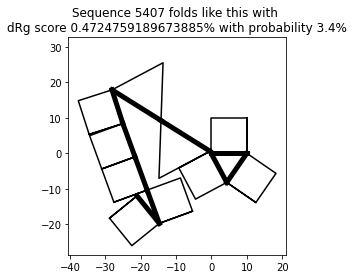

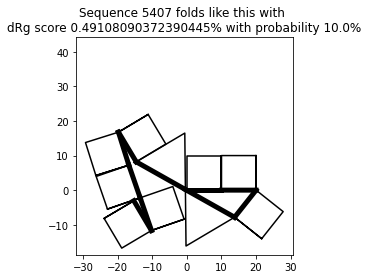

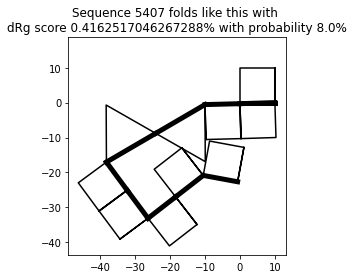

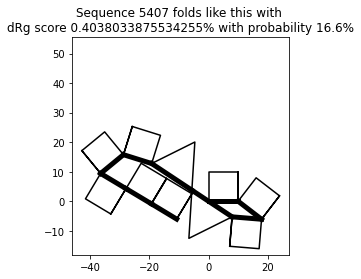

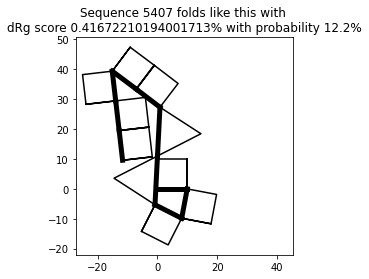

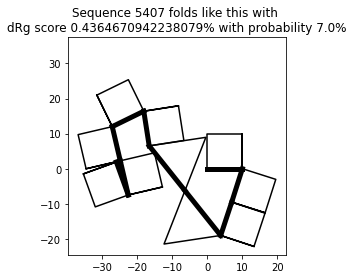

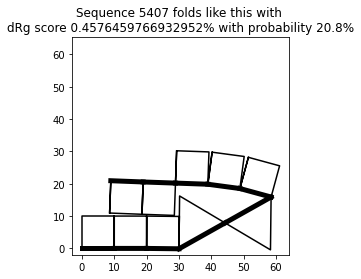

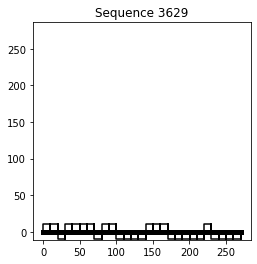

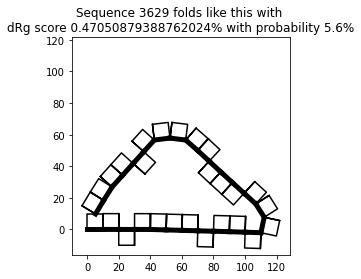

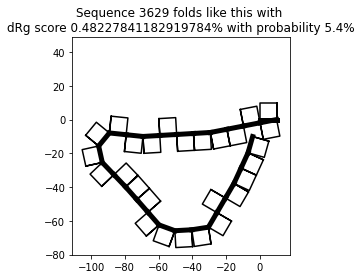

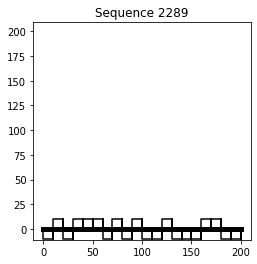

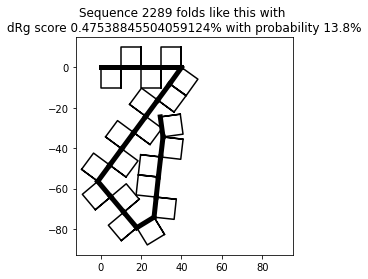

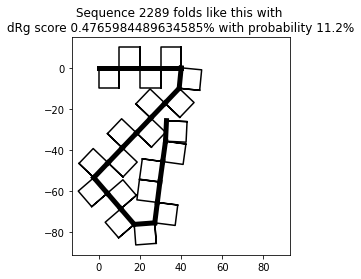

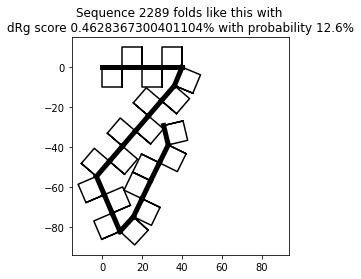

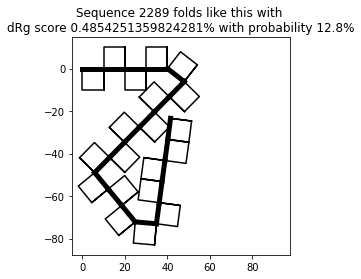

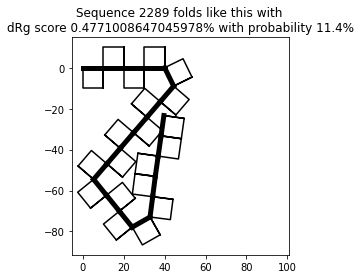

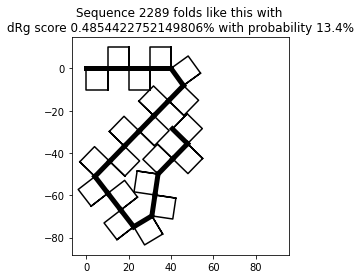

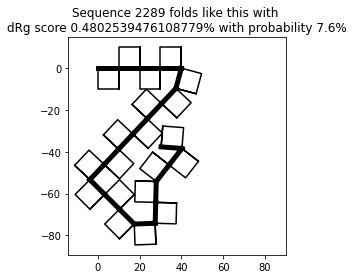

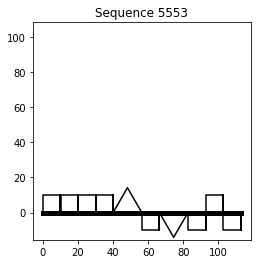

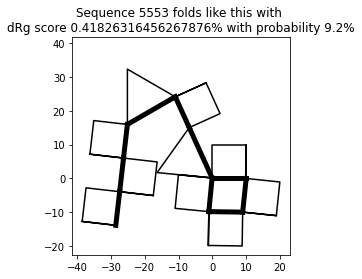

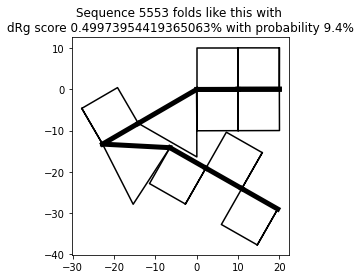

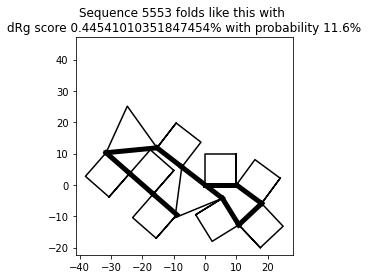

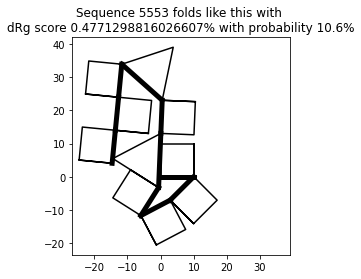

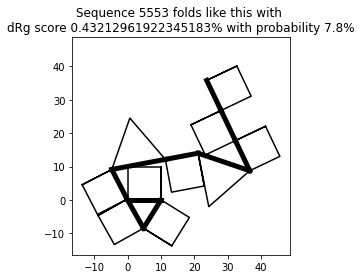

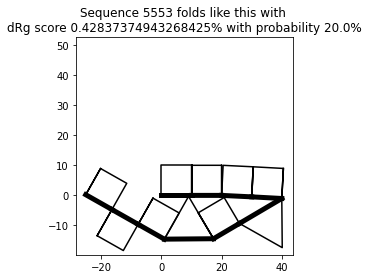

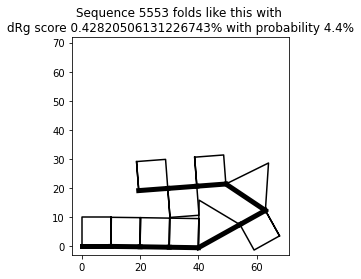

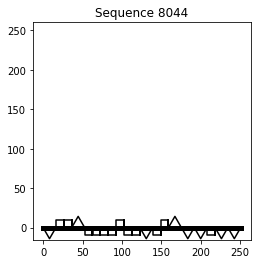

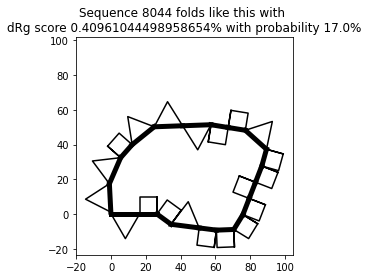

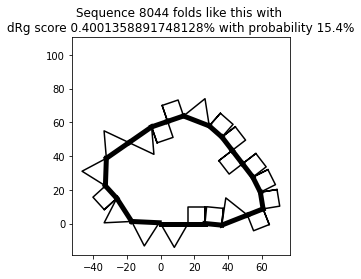

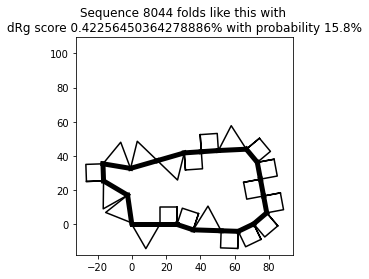

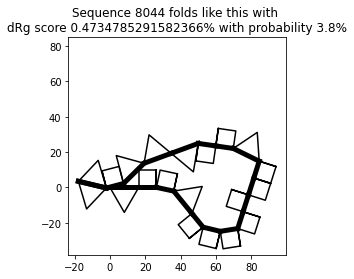

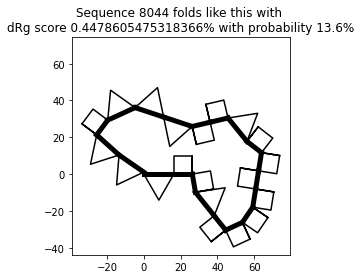

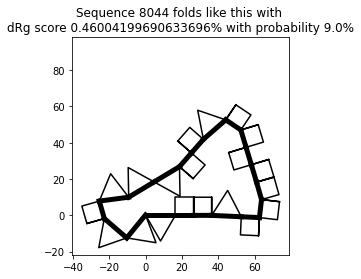

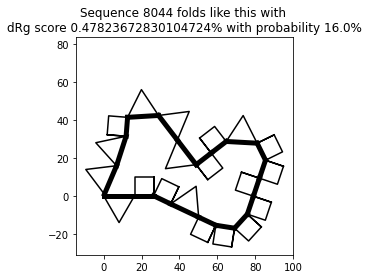

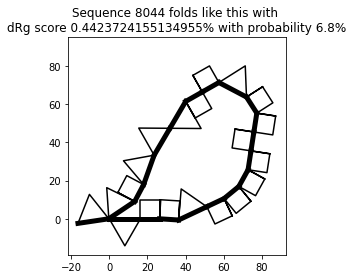

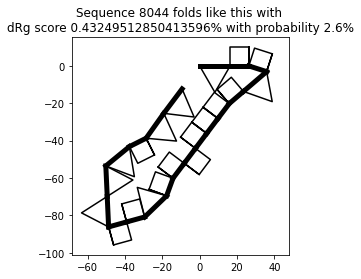

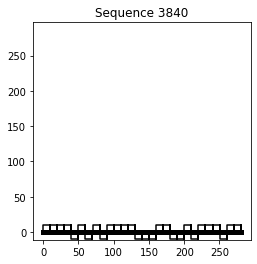

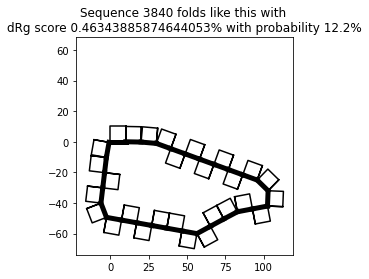

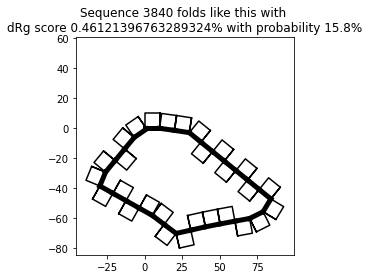

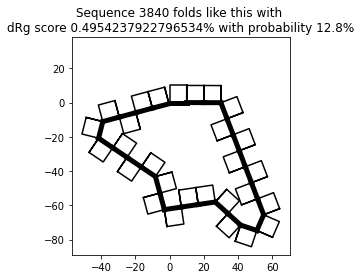

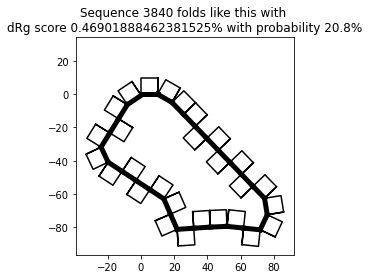

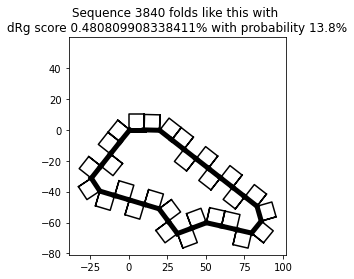

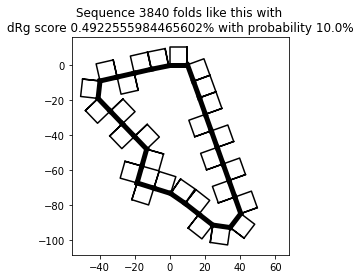

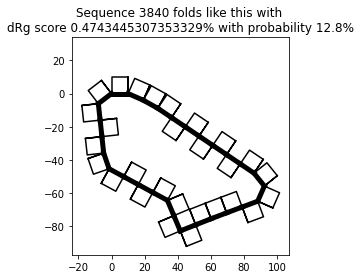

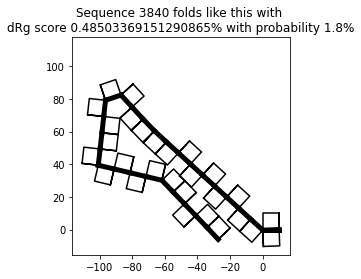

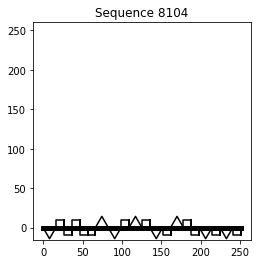

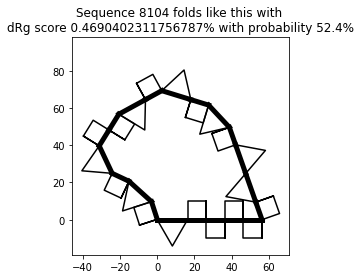

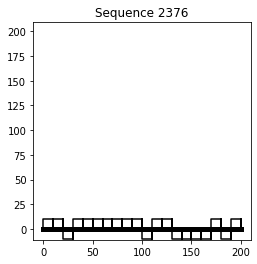

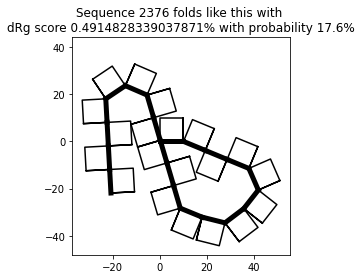

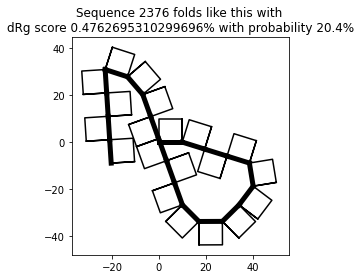

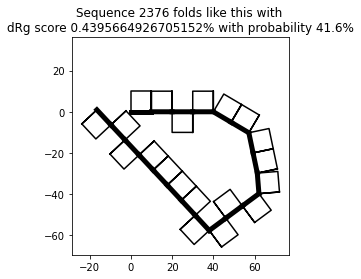

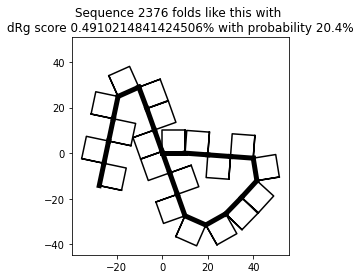

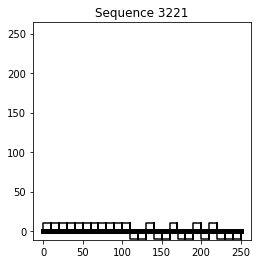

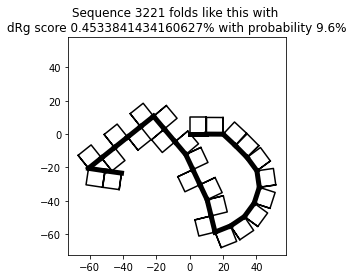

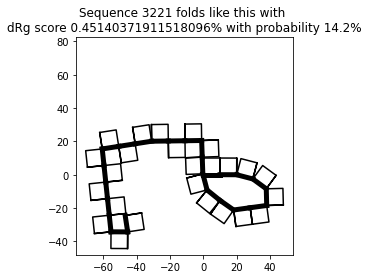

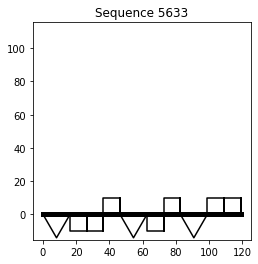

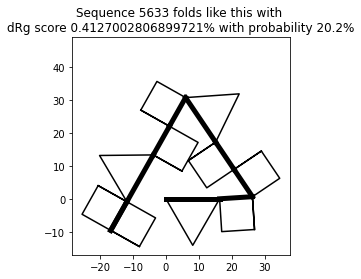

In [27]:
dRg_min = 0.4
dRg_max = 0.5
random_number = 10 #number of sequences to display, sampling at random
structures, structure_list = mc.determine_unique_structures_range(filtered_length_t, dRg_min,dRg_max, 'dRg', length_list = [],
                                                                  show_structures = True, random_number = random_number)

## Symmetry Data

##### Load in data again

In [28]:
path = os.getcwd()

filename_squares = path + '/analyzed_tutorial_subset.csv'
df_squares = mc.load_mainframe(filename)

filename_shapes_10 = path + '/analyzed_ssims_10_4G.csv'
df_shapes_10 = pd.read_csv(filename_shapes_10,index_col = 0)

filename_shapes_20 = path + '/analyzed_ssims_20_evens_4G.csv'
df_shapes_20 = pd.read_csv(filename_shapes_20,index_col = 0)

##### Combine the data

In [29]:
analyzed_mainframe = pd.concat([df_squares,df_shapes_10,df_shapes_20])
analyzed_mainframe.reset_index(drop=True, inplace=True)
analyzed_mainframe.index = analyzed_mainframe.index.map(lambda x: f'Sequence {x + 1}')
analyzed_mainframe = analyzed_mainframe.applymap(mc.deserialize_complex_data)
length_list = sorted(list(set(df_squares.loc[:,'length'])))[:-1]

##### Filter for lengths of interest only and plot symmetry score histogram

0.9999841443778628


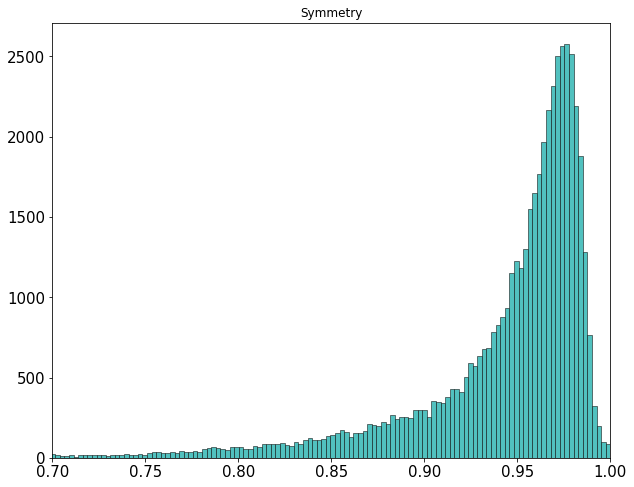

In [30]:
filtered_length_t= mc.filter_df(length_list,analyzed_mainframe)
mc.sym_histogram(filtered_length_t)

##### Filter for desired symmetry values

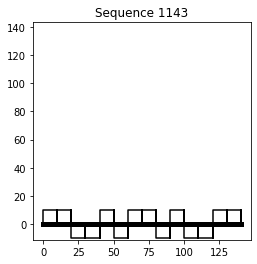

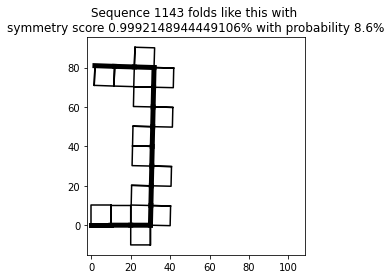

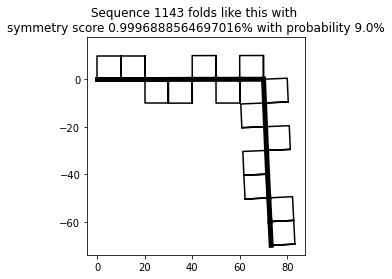

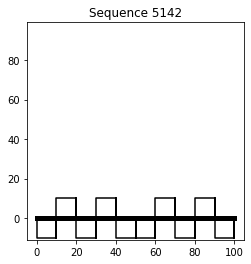

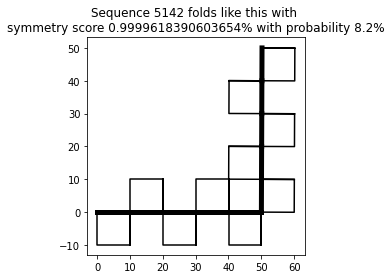

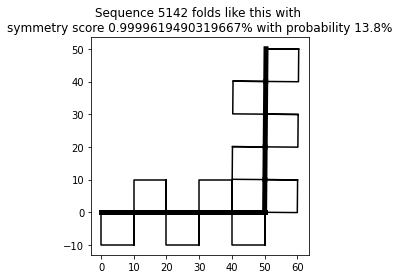

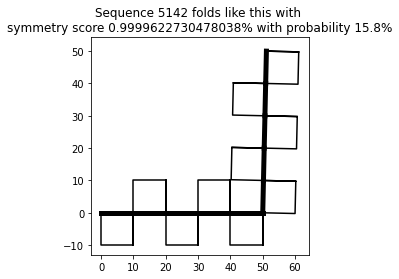

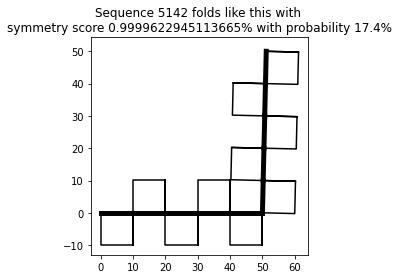

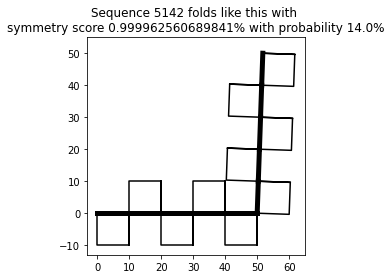

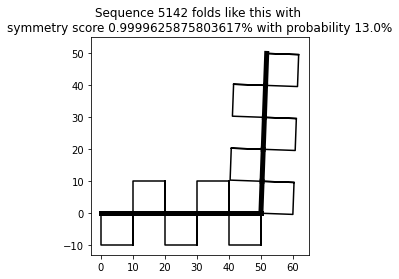

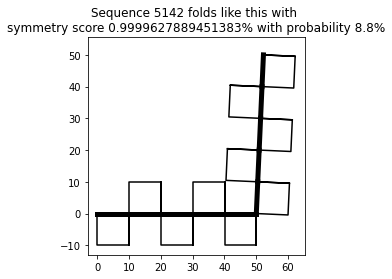

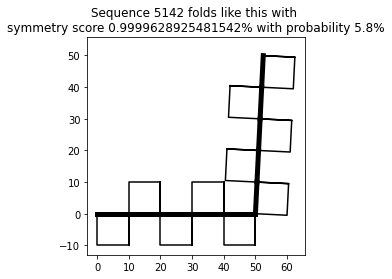

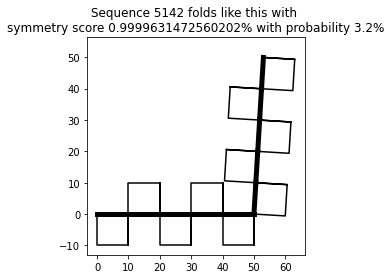

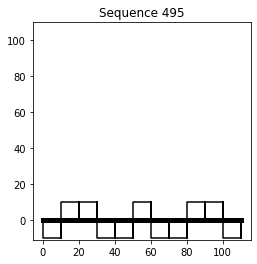

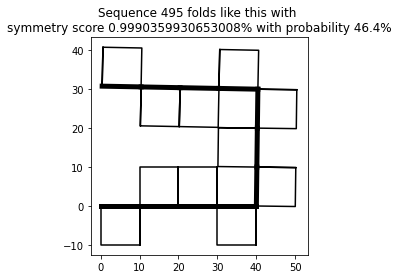

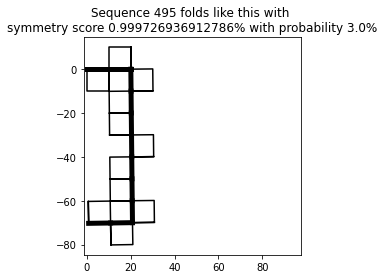

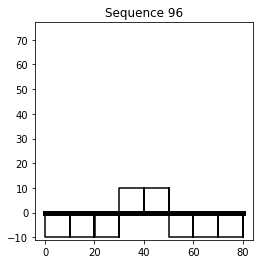

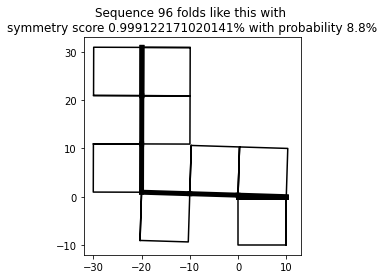

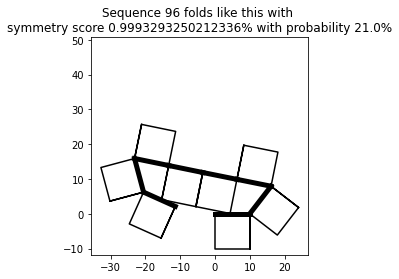

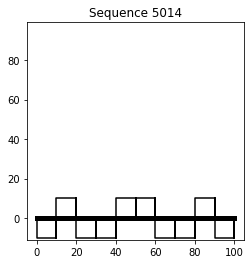

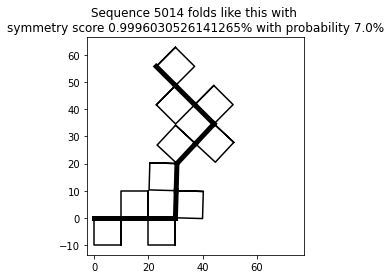

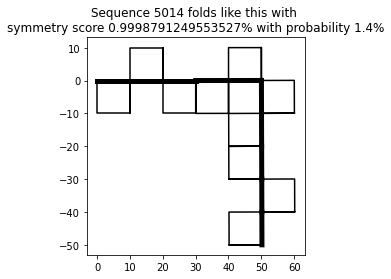

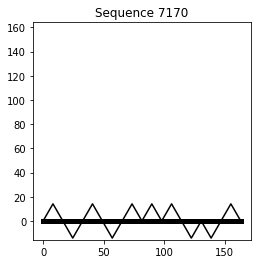

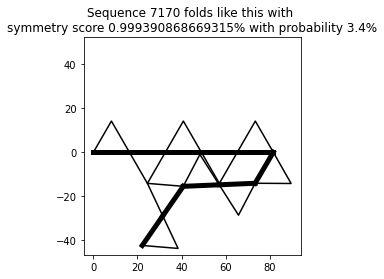

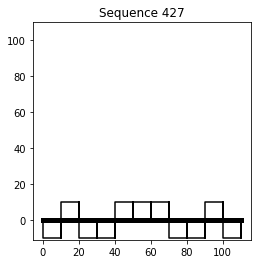

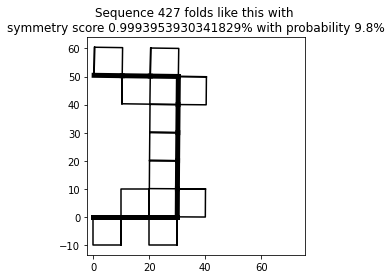

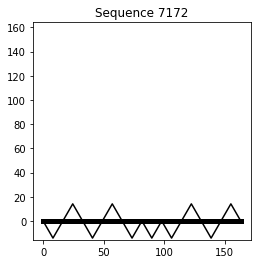

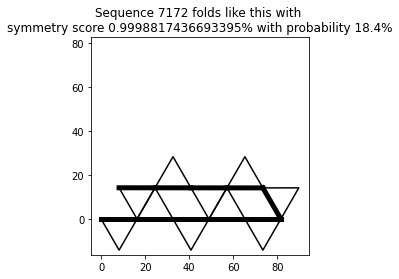

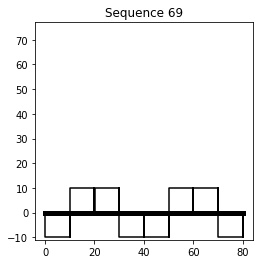

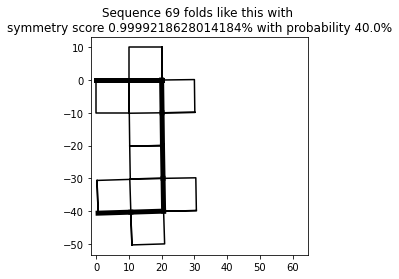

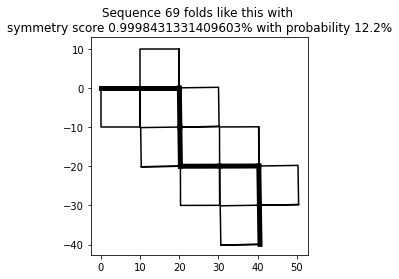

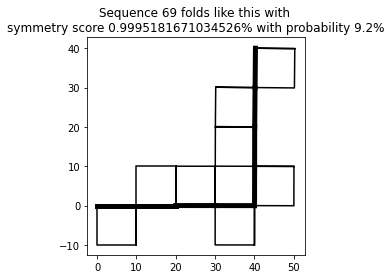

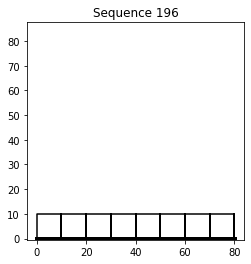

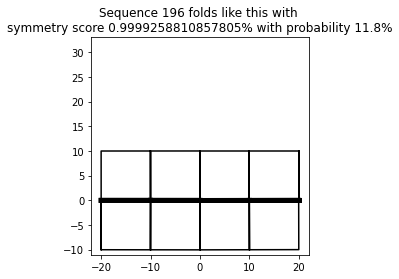

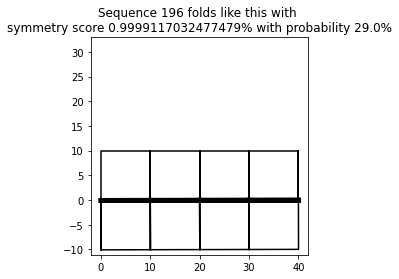

In [37]:
sym_min = 0.999
sym_max = 1
random_number = 10 #number of sequences to display, sampling at random
structures, structure_list = mc.determine_unique_structures_range(filtered_length_t, sym_min,sym_max, 'symmetry', length_list = [],
                                                                  show_structures = True, random_number = random_number)

## Tortuosity Data

##### Load in data

In [38]:
path = os.getcwd()

filename_squares = path + '/analyzed_tutorial_subset.csv'
df_squares = mc.load_mainframe(filename)

filename_shapes_10 = path + '/analyzed_ssims_10_4G.csv'
df_shapes_10 = pd.read_csv(filename_shapes_10,index_col = 0)

filename_shapes_20 = path + '/analyzed_ssims_20_evens_4G.csv'
df_shapes_20 = pd.read_csv(filename_shapes_20,index_col = 0)

##### Combine Data

In [39]:
analyzed_mainframe = pd.concat([df_squares,df_shapes_10,df_shapes_20])
analyzed_mainframe.reset_index(drop=True, inplace=True)
analyzed_mainframe.index = analyzed_mainframe.index.map(lambda x: f'Sequence {x + 1}')
analyzed_mainframe = analyzed_mainframe.applymap(mc.deserialize_complex_data)
length_list = sorted(list(set(df_squares.loc[:,'length'])))[:-1]

##### Filter by length and plot tortuosity histogram

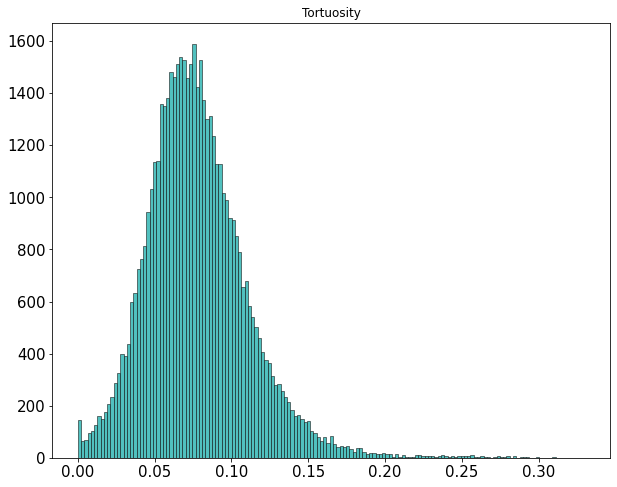

array([0.28332014, 0.17353672, 0.12989807, ..., 0.0602771 , 0.05639969,
       0.06158087])

In [40]:
filtered_length_t= mc.filter_df(length_list,analyzed_mainframe)
mc.T_histogram(filtered_length_t)

##### Filter structures within a defined tortuosity range

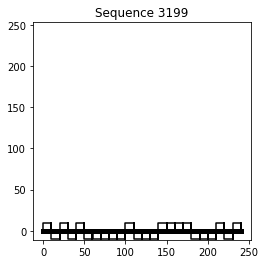

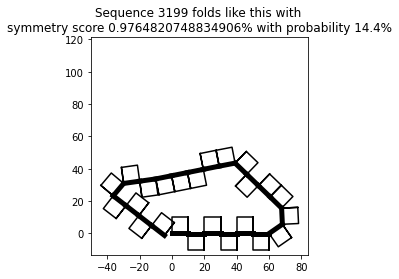

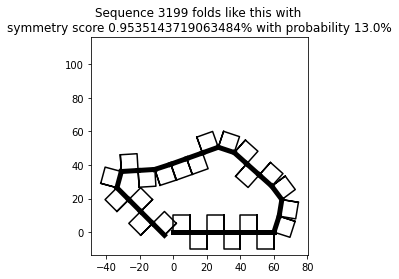

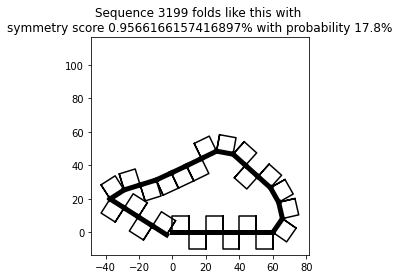

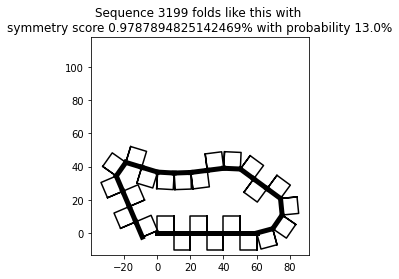

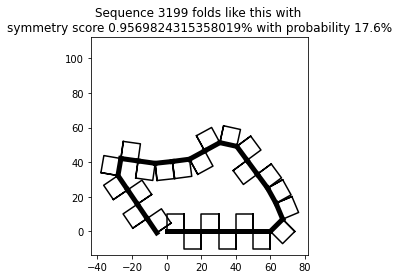

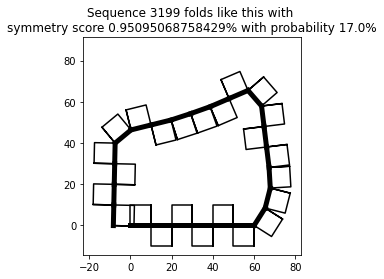

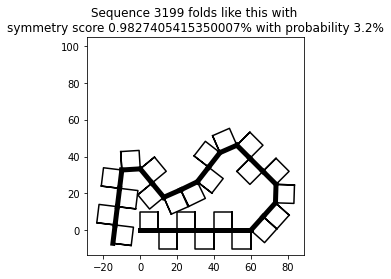

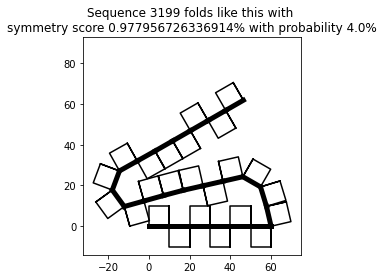

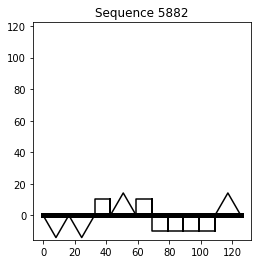

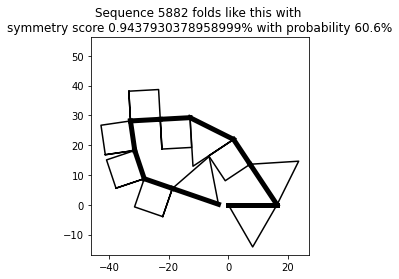

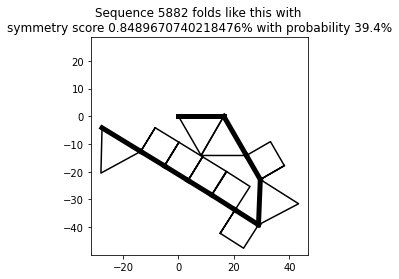

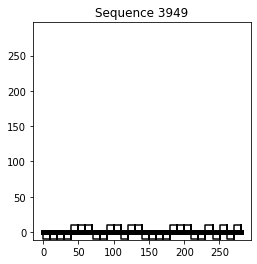

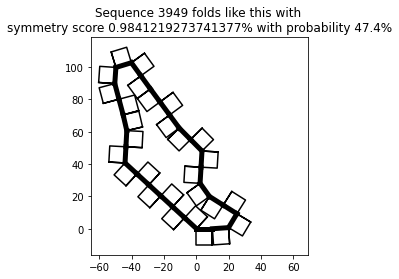

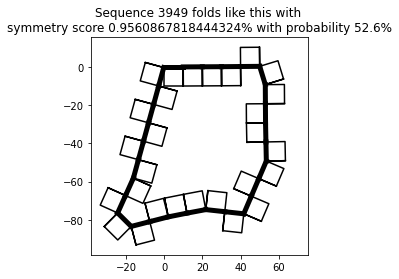

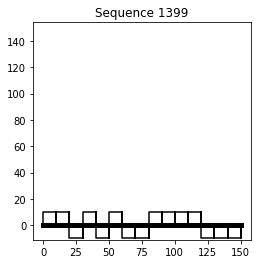

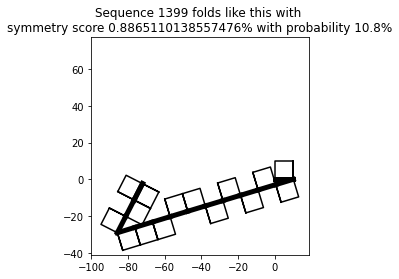

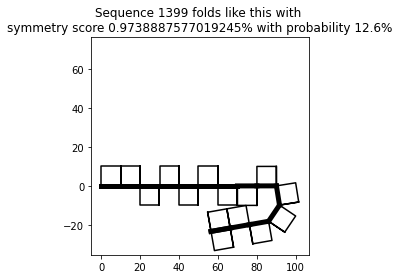

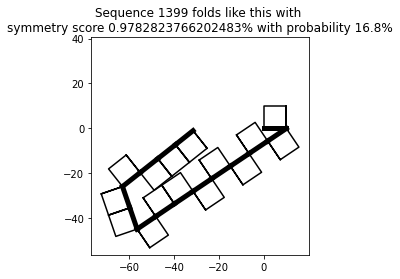

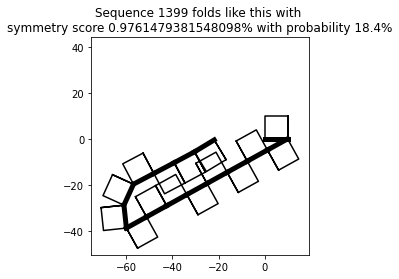

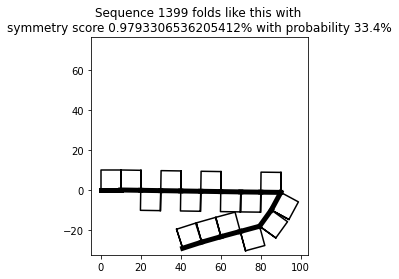

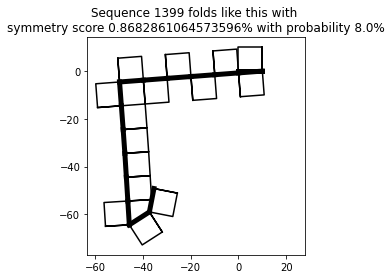

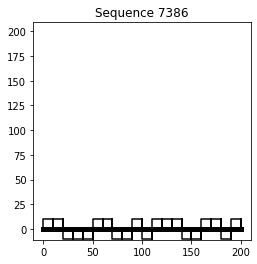

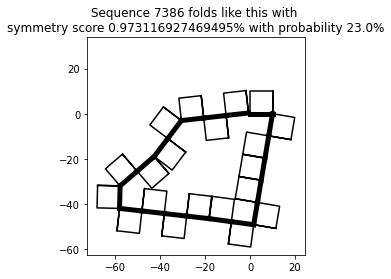

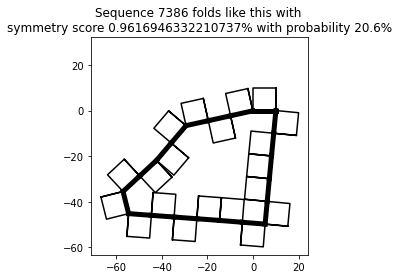

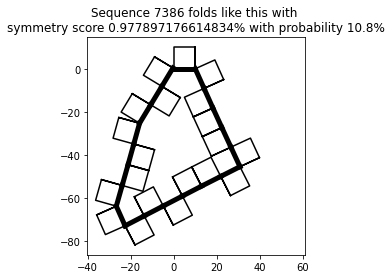

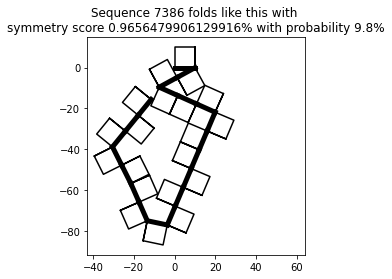

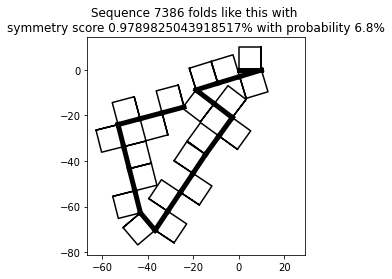

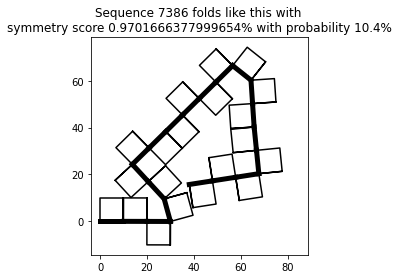

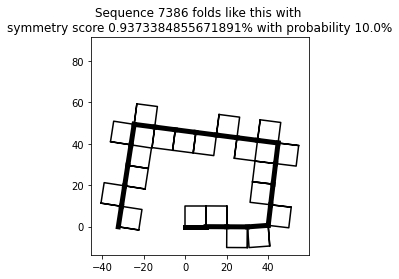

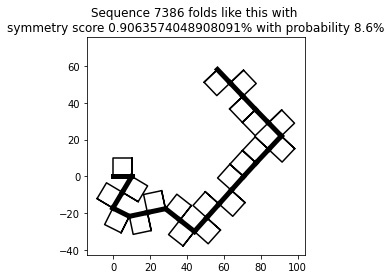

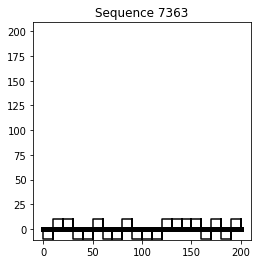

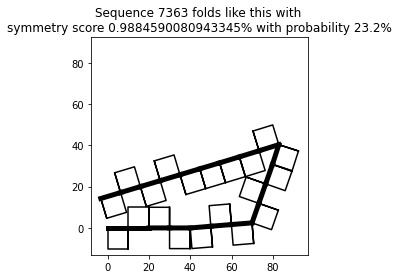

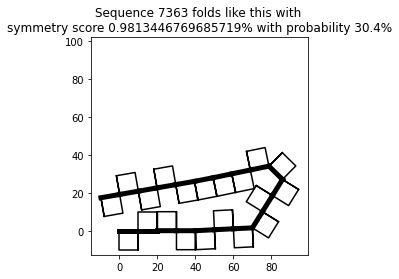

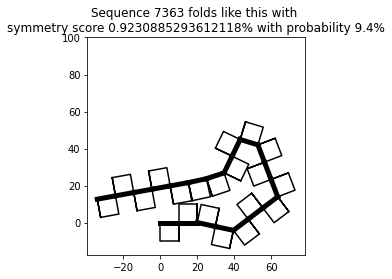

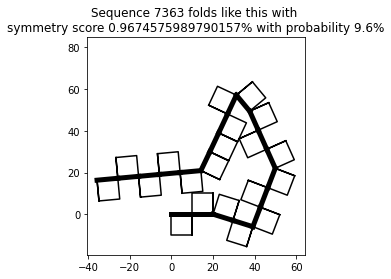

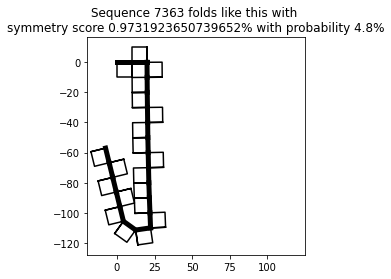

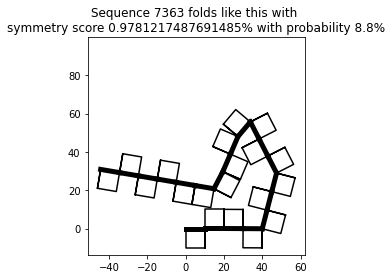

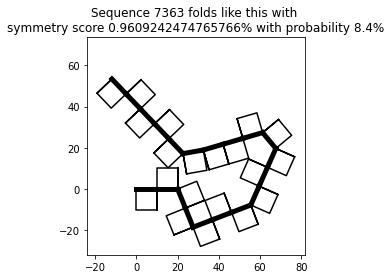

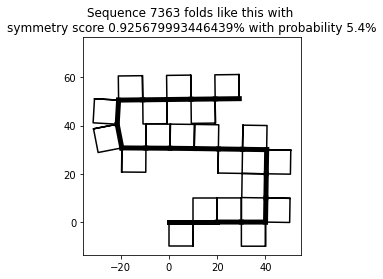

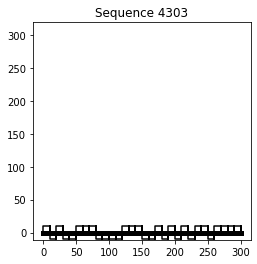

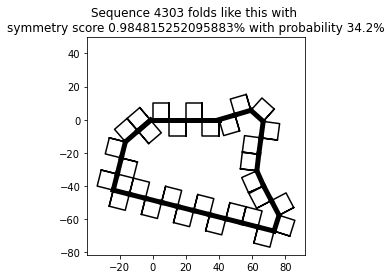

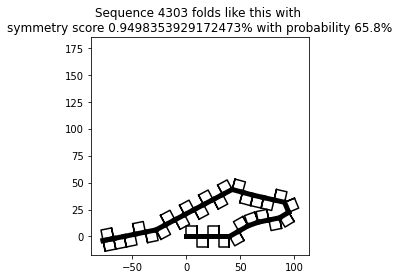

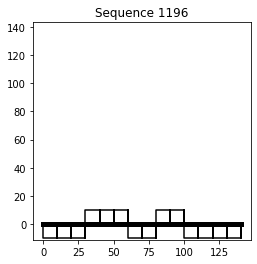

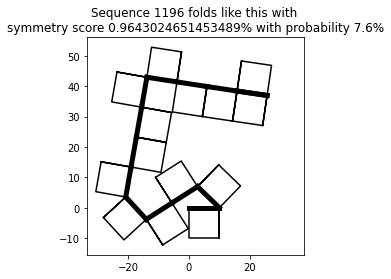

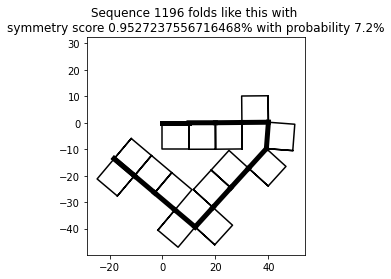

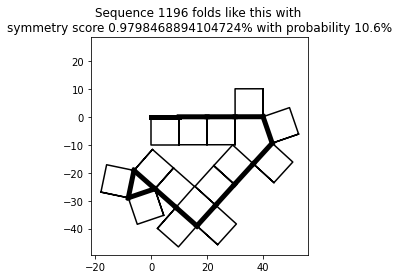

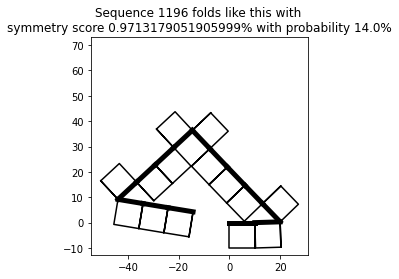

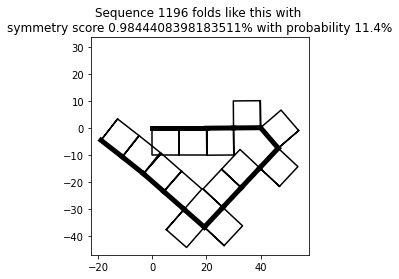

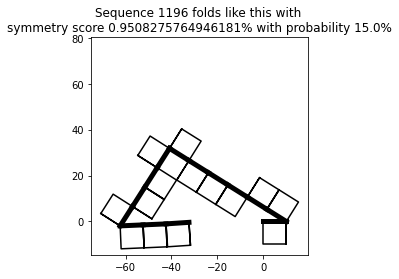

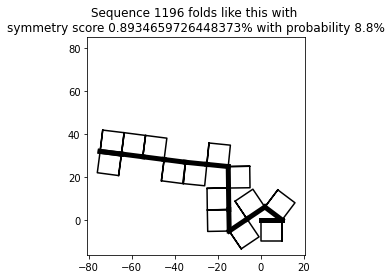

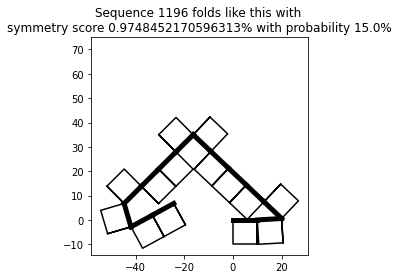

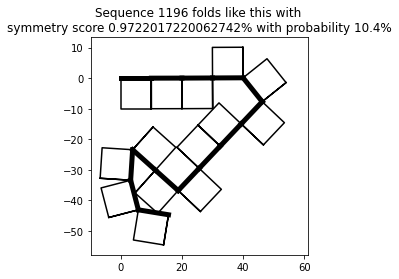

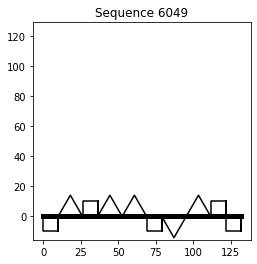

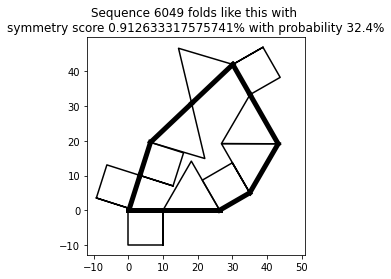

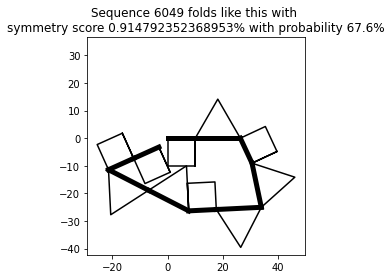

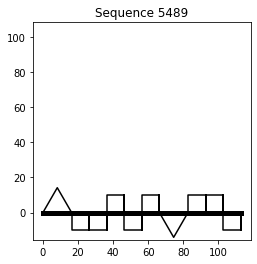

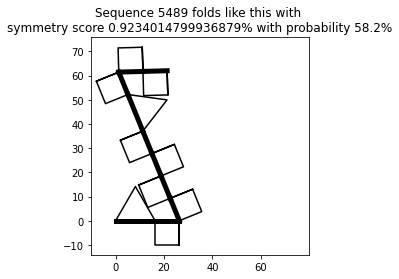

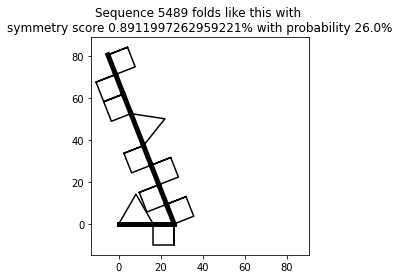

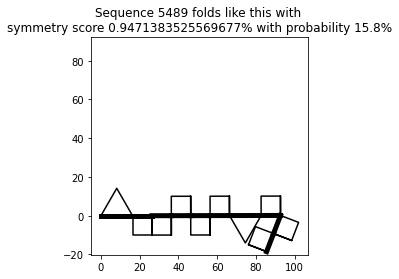

In [41]:
T_min = 0.3
T_max = 1
random_number = 10 #number of sequences to display, sampling at random
structures, structure_list = mc.determine_unique_structures_range(filtered_length_t, T_min,T_max, 'symmetry', length_list = [],
                                                                  show_structures = True, random_number = random_number)

## Find Closed Loops

##### View sequences that form closed loops

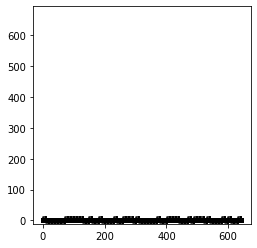

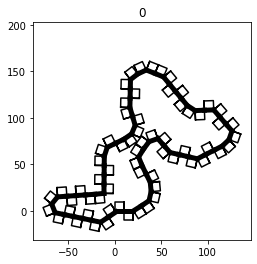

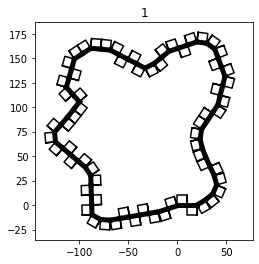

In [ ]:
random_number = 10
structures = mc.find_closed_loops(analyzed_mainframe, show_structures = False)
choices = np.round(np.random.sample(random_number)*len(structures))
for i in choices:
    mc.show_sequence(structures[int(i)],analyzed_mainframe)